__CoT Final Report__

### Import

In [48]:
import os
import sys
from datetime import datetime
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, KFold, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



### Function Definition

In [86]:
def plotMissing(df,save=False,title='Missing Values'):
    #Missing value plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

def tsplot1(y, lags=None, figsize = (11,8), style = 'bmh',title = None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,3)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 3) 
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,2))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha = 0.05) #autocorrelations, alpha is the hypothesis testing error bars.
        sm.qqplot(y, line = 's', ax=qq_ax)
        plot_pacf(y, lags = lags,alpha = .05, ax =pacf_ax )
        qq_ax.set_title('QQ PLot')
        plt.tight_layout() #keep into tight configuration. 
    return


def compareplot(y,y_pred,figsize):
    fig = plt.figure(figsize = (8,6))
    plt.plot(y_pred, label = "Forecast")
    plt.plot(y, label = "AM_N_Pos")
    plt.tight_layout()
    plt.legend()

def scorecard(method,err,y):
    global pos_score
    mse=np.round(np.mean(err**2)/1000000,3)
    mae=np.round(np.mean(np.abs(err)),3)
    ape=np.round(np.mean(np.abs((err)/y)),3)
    pos_score['MSE'][method] = mse
    pos_score['MAE'][method] = mae
    pos_score['APE'][method] = ape   
    print("Model:",method)
    print('MSE is {0:.2f}'.format(mse))
    print('MAE is {0:.2f}'.format(mae))
    print('APE is {0:.2f}'.format(ape))

def evaluate(method, y, y_pred,lags = None, figsize = (13,14), style = 'bmh'):
    sns.set(font_scale = 1)
    err = y_pred - y
    scorecard(method,err,y)
    #compareplot(y,y_pred,figsize)
    if not isinstance(err,pd.Series):
        err = pd.Series(err)
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    if not isinstance(y_pred,pd.Series):
        y_pred = pd.Series(y_pred)
    
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3,3)
        pr_ax = plt.subplot2grid(layout, (0,0),colspan = 3)
        ts_ax = plt.subplot2grid(layout, (1,0),colspan = 3)
        ft_ax = plt.subplot2grid(layout, (2,2))
        qq_ax = plt.subplot2grid(layout,(2,0))
        acf_ax = plt.subplot2grid(layout,(2,1))
        
        pr_ax.set_title(method +' Forecast vs AM Net Position')
        y.plot(ax = pr_ax, label ="AM Net Pos", color = "tab:blue")
        y_pred.plot(ax = pr_ax, label ="Forecast", color = "tab:orange", alpha = .7)
        pr_ax.legend(loc = 0, fontsize = 'large')
        
        ts_ax.set_title('Residuals Plot')
        err.plot(ax = ts_ax)
        
        acf_ax.set_title('Error ACF')
        smt.graphics.plot_acf(err,lags = lags, ax = acf_ax, alpha = .05)
        
        ft_ax.set_title('Actual vs Pred')
        ft_ax.plot([0, 1], [0, 1], transform=ft_ax.transAxes, ls="--", c="red")
        sns.scatterplot(y_pred,y,ax = ft_ax)
        
        qq_ax.set_title('QQ Plot')
        sm.qqplot(err,line = 's',ax = qq_ax)
        plt.tight_layout()
    return

def ErrorTest(y, y_pred):
    print(acorr_ljungbox(y - y_pred, lags = 10, return_df = True)[:3],"\n")
    res = sm.tsa.arma_order_select_ic(y - y_pred, ic=['aic', 'bic'], trend = 'nc')
    print("AIC Order Select:",res.aic_min_order)
    print("BIC Order Select:",res.bic_min_order)

#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,:-1].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.4,annot=True,annot_kws={"size":8},fmt='.1f',cbar_kws={"shrink": .4}, mask=mask, cmap="coolwarm")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

#Test to ensure rolling window logic functions correctly
def Rebal_Dates(data, est = 123, wind = 5):
    periods = data.shape[0]
    rebal_count = (periods-est)//wind
    #print(periods)
    #print(est)
    #print(wind)
    #print(rebal_count)
    rebal_dates = []
    for i in range (0,rebal_count):
        #print("Rebal #:",i+1)
        #print("ESTIMATION________________")
        full = df_preCOV.iloc[i*wind:est+i*wind+wind,:].index
        #print("Starts :",full[0])
        #print("Stops  :",full[-1])
        train = full[:est]
        #print("TRAIN____________________")
        #print("Starts :",train[0])
        #print("Stops  :",train[-1])
        test = full[ est : est+ wind]
        #print("TEST____________________")
        rebal_dates.append(test[0])
        #print("Starts :",test[0])
        #print("Stops  :",test[-1])
        #print("\n")
    count = len(rebal_dates)
    return rebal_dates, count

def Lasso(X_train_std, X_test_std, y_train): 
    lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
    lasso.fit(X_train_std, y_train)
    forecast = lasso.predict(X_test_std)
    coef = lasso.coef_
    alpha = lasso.alpha_      
    return  coef, alpha, forecast

def Ridge(X_train_std, X_test_std, y_train): 
    ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
    ridge.fit(X_train_std, y_train)
    forecast = ridge.predict(X_test_std)
    coef = ridge.coef_
    alpha = ridge.alpha_ 
    return coef, alpha, forecast

def RF(X_train_std, X_test_std, X_train, y_train,tscv):  
    rf2 = RandomForestRegressor(n_estimators = 30, max_depth = 6, max_features = 'sqrt')
    p = X_train_std.shape[1]
    param_grids_random = {
    'max_depth': [2, 3, 5, 6, 8, 10],
    'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]
    }
    random_grid_search = RandomizedSearchCV(estimator = rf2,param_distributions = param_grids_random,\
                                            scoring='neg_mean_absolute_error',cv=tscv, n_iter = 40)\
                                            .fit(X_train_std, y_train)
    params = list(random_grid_search.best_params_.values())
    n_est, mxdpth = params[0],params[1]
    rf2 = RandomForestRegressor(n_estimators = n_est, max_depth = mxdpth, max_features = 'sqrt')
    X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns)
    rf2.fit(X_train_std_df, y_train)
    forecast = rf2.predict(X_test_std)
    feat_importance = pd.Series(rf2.feature_importances_,index = X_train.columns)
    fis = np.argsort(feat_importance)
    feat_importance = feat_importance[fis]
    return feat_importance, forecast

def ElasticNet(X_train_std, X_test_std, y_train):
    EN = ElasticNetCV(l1_ratio = np.linspace(0.4, 1, 10), alphas = np.logspace(1,2,20, base = np.exp(1)), max_iter = 10000)
    EN.fit(X_train_std, y_train)
    forecast = EN.predict(X_test_std)
    coef = EN.coef_
    alpha = EN.alpha_ 
    return coef, alpha, forecast

def SVReg(X_train_std, X_test_std, y_train):
    tscv = TimeSeriesSplit(n_splits = 5)
    svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),cv = tscv, param_grid={"C": [1e0, 1e1, 1e2, 1e3],\
                        "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std, y_train)
    svr.fit(X_train_std, y_train)
    forecast = svr.predict(X_test_std)
    return forecast

def VRMX(trans_df):
    mod = sm.tsa.VARMAX(trans_df,order=(1,1),error_cov_type='diagonal')
    res = mod.fit(maxiter=1000, disp=False)
    y_predict = prediction['AM_N'].iloc[0]
    return y_predict

def Rolling(PredModel, est_window, pred_window):    
    periods = df_preCOV.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind    #need to include initial estimation
    idx = df_preCOV.iloc[est:,:].index
    coefs = []
    alphas = []
    pred = []
    MSE = []
    MAE = []
    APE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (0,rebal_count):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        full = df_preCOV.iloc[i*wind:est+i*wind+wind,:].dropna(axis = 1)
        
        #we already pulled a data frame of correct length, so now we partition it into 2.
        full_train = full.iloc[:est,:]
        full_test = full.iloc[ est : est+ wind ,:]
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]
        
        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        if PredModel == 'Lasso':
            coef, alpha, forecast = Lasso(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-4])
            alphas.append(np.log(alpha))
        
        if PredModel == 'Ridge':
            coef, alpha, forecast = Ridge(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-2])
            alphas.append(np.log(alpha))
        
        if PredModel == 'ElasticNet':
            coef, alpha, forecast = ElasticNet(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-2])
            alphas.append(np.log(alpha)) 
        
        if PredModel == "SVReg":
            forecast = SVReg(X_train_std, X_test_std, y_train)    
        
        #store results
        err = y_test - forecast
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(np.round(np.mean(err**2)/1000000,3))
        MAE.append(np.round(np.mean(np.abs(err)),3))
        APE.append(np.round(np.mean(np.abs((err)/y_test)),3)) 
   
    pred = pd.Series(pred, index = idx)
    y_true = pd.Series(y_true, index = idx)
    MSE = np.mean(MSE)
    MAE = np.mean(MAE)
    APE = np.mean(APE)
    return pred, MSE, MAE, APE, var_sel, y_true, idx
    
def Expanding(PredModel, est_window, pred_window):    
    tscv = TimeSeriesSplit(n_splits = 9)
    periods = df_preCOV.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind    #need to include initial estimation
    idx = df_preCOV.iloc[est:,:].index
    coefs = []
    alphas = []
    pred = []
    MSE = []
    MAE = []
    APE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (est,len(df_preCOV), wind):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        full = df_preCOV.iloc[:i+wind,:].dropna(axis = 1)
        
        #we already pulled a data frame of correct length, so now we partition it into 2.
        full_train = full.iloc[:i,:]
        full_test = full.iloc[ i : i+ wind ,:]
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]
        
        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        #fit our model to the training set        
        if PredModel == 'RF':
            feat_importance, forecast = RF(X_train_std, X_test_std, X_train, y_train,tscv)
            var_sel[i] = list(feat_importance)
        
        if PredModel == "SVReg":
            forecast = SVReg(X_train_std, X_test_std, y_train)
        
        if PredModel == 'GAM':
            print('not done')
            
        if PredModel == 'GradBoost':
            print('not done')
        
        if PredModel == 'VRMX':
            cols = ['lag_AM_N','ret_SPX Index']
            X_train = X_train.reindex(cols,axis="columns")   
            #print(X_train)
            X_test = X_test.reindex(cols,axis="columns")
            #print(X_test)
            transformer = Normalizer()
            transformer.fit(X_train)
            #print(transformer)
            X_train_norm = transformer.transform(X_train)
            #print(X_train_norm)
            X_test_norm = transformer.transform(X_test)
            trans_df=np.append(X_train_norm,np.array(y_train).reshape(len(X_train_norm),1),1)
            forecast = VRMX(trans_df)
            
    
        #store results
        err = y_test - forecast
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(np.round(np.mean(err**2)/1000000,3))
        MAE.append(np.round(np.mean(np.abs(err)),3))
        APE.append(np.round(np.mean(np.abs((err)/y_test)),3)) 
   
    pred = pd.Series(pred, index = idx)
    y_true = pd.Series(y_true, index = idx)
    MSE = np.mean(MSE)
    MAE = np.mean(MAE)
    APE = np.mean(APE)
    return pred, MSE, MAE, APE, var_sel, y_true, idx


### Data Load

In [3]:
df_raw=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date", parse_dates = True)

#Drop price columns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df_raw.drop(columns = cols)

#add 2020 to a df
df_insane = df.iloc[-48:,:]

#remove 2020 from the sample, but keep NA vals for now
df_preCOV = df.iloc[:-48,:]

#Now remove NA's before passing to training.  Train and test end up w/ different shapes if you don't drop before this.
df_trimmed = df_preCOV.dropna(axis = 1)

#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
df_train = df_trimmed.iloc[:390,:]
df_test = df_trimmed.iloc[390:,:]

diff_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])
pos_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])

roll_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])


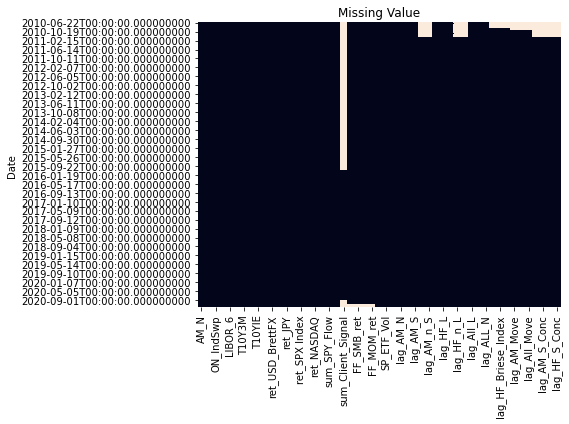

In [4]:
plotMissing(df)

### EDA: Response

The Asset Managers Net Position time series exhibits significant autocorrelation, with the partial autocorrelation function suggesting an AR(1) process.

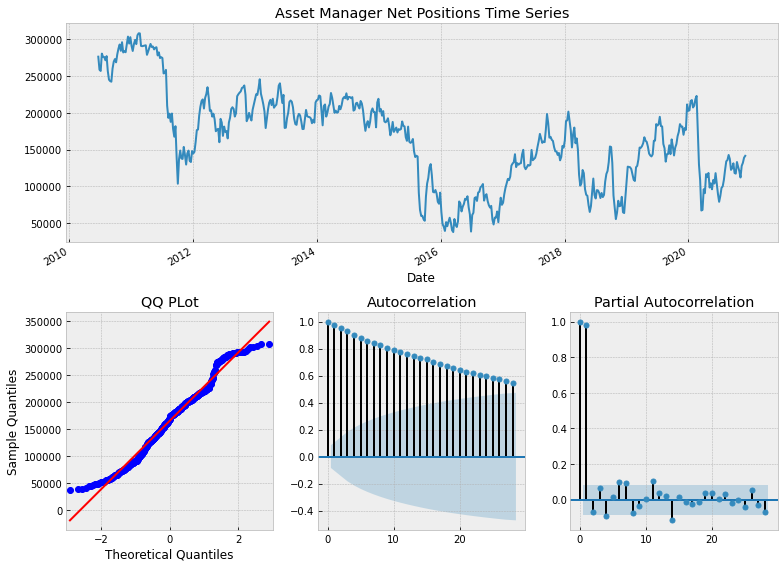

In [5]:
tsplot1(df['AM_N'],title = 'Asset Manager Net Positions Time Series')

Estimating the Order of a Time Series Model

In [6]:
res = sm.tsa.arma_order_select_ic(df['AM_N'], ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (4, 2)
BIC Order Select: (1, 0)


For simplicity, we'll assume AM Net Positions are AR(1) and form our prediction around both the difference and level of the repsonse with the lagged response as a predictor.  There did not appear to be a strong indication for AR(2) in the PACF.

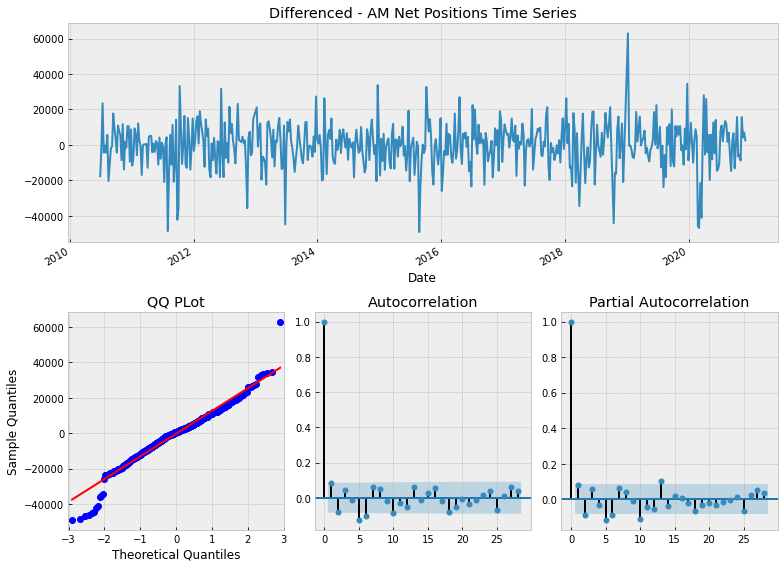

In [7]:
#Differencing
AM_N_diff = df['AM_N'].diff().dropna()
tsplot1(AM_N_diff,title = 'Differenced - AM Net Positions Time Series')

In [8]:
res = sm.tsa.arma_order_select_ic(AM_N_diff, ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (4, 2)
BIC Order Select: (0, 1)


### EDA: Predictors

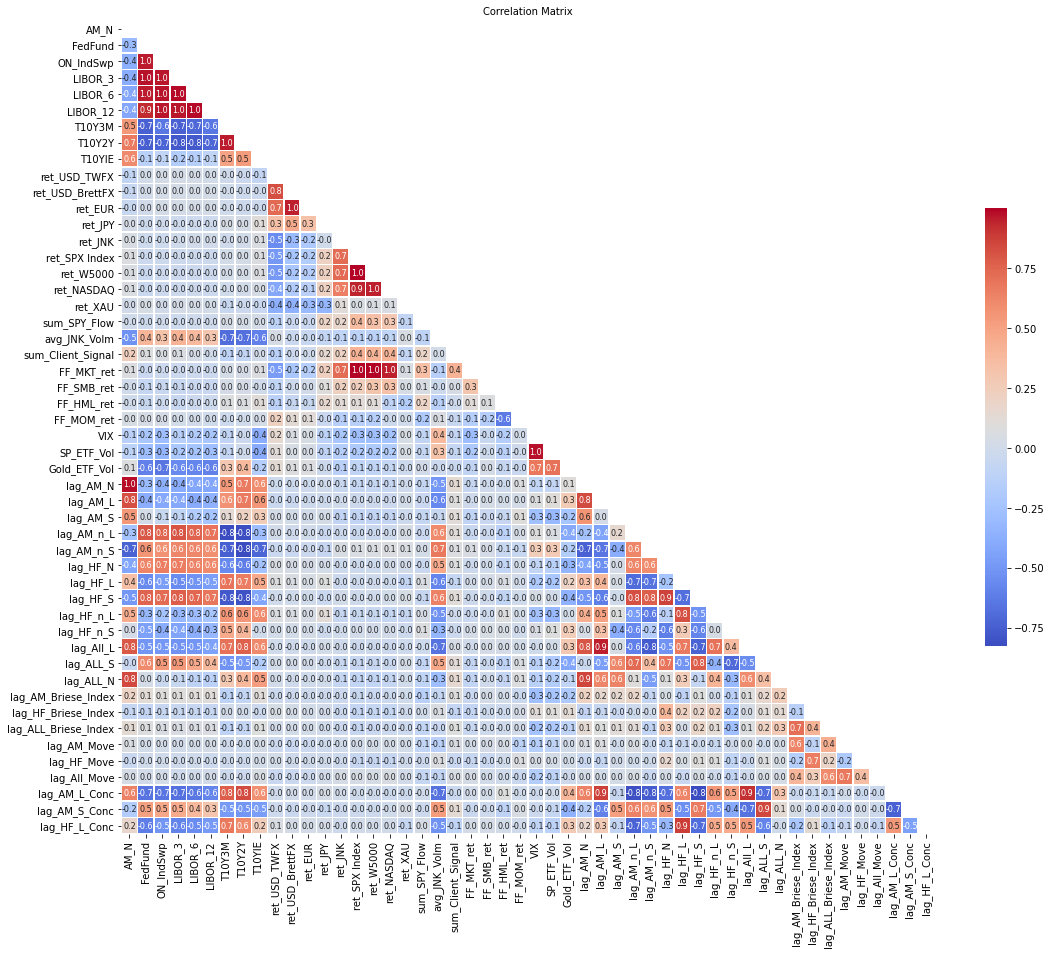

In [9]:
plotCorr(df,save=False)

#### Predictor Distributions

In [11]:
Asset = {'AM Position':['lag_AM_N','lag_AM_L','lag_AM_S'],
         'HF Position':['lag_HF_N','lag_HF_L','lag_HF_S'],
         'All Position':['lag_All_L', 'lag_ALL_S', 'lag_ALL_N'],
         'Concentration':['lag_AM_L_Conc', 'lag_AM_S_Conc','lag_HF_L_Conc', 'lag_HF_S_Conc'],
         'Sentiment':['lag_AM_Briese_Index', 'lag_HF_Briese_Index', 'lag_ALL_Briese_Index'],
         'Movement' :['lag_AM_Move','lag_HF_Move','lag_All_Move'],
         'Int_Rate':['FedFund', 'ON_IndSwp'],
         'LIBOR':['LIBOR_3', 'LIBOR_6','LIBOR_12'],
         'YTM Spread':['T10Y3M','T10Y2Y'],
         'Inflation':['T10YIE'],
         'FX Returns': [ 'ret_USD_TWFX','ret_USD_BrettFX', 'ret_EUR','ret_JPY'],      
         'Junk_Bond Returns':['ret_JNK'],
         'Equity Returns':['ret_SPX Index','ret_W5000', 'ret_NASDAQ'],
         'FamaFrench':['FF_MKT_ret', 'FF_SMB_ret', 'FF_HML_ret', 'FF_MOM_ret'],
         'ETF_Flows':['sum_SPY_Flow'],
         'Vol':['VIX', 'SP_ETF_Vol', 'Gold_ETF_Vol'],
         'Signal':['sum_Client_Signal'],
         'Commodity':['ret_XAU']       
        }
key_list = list(Asset.keys()) 

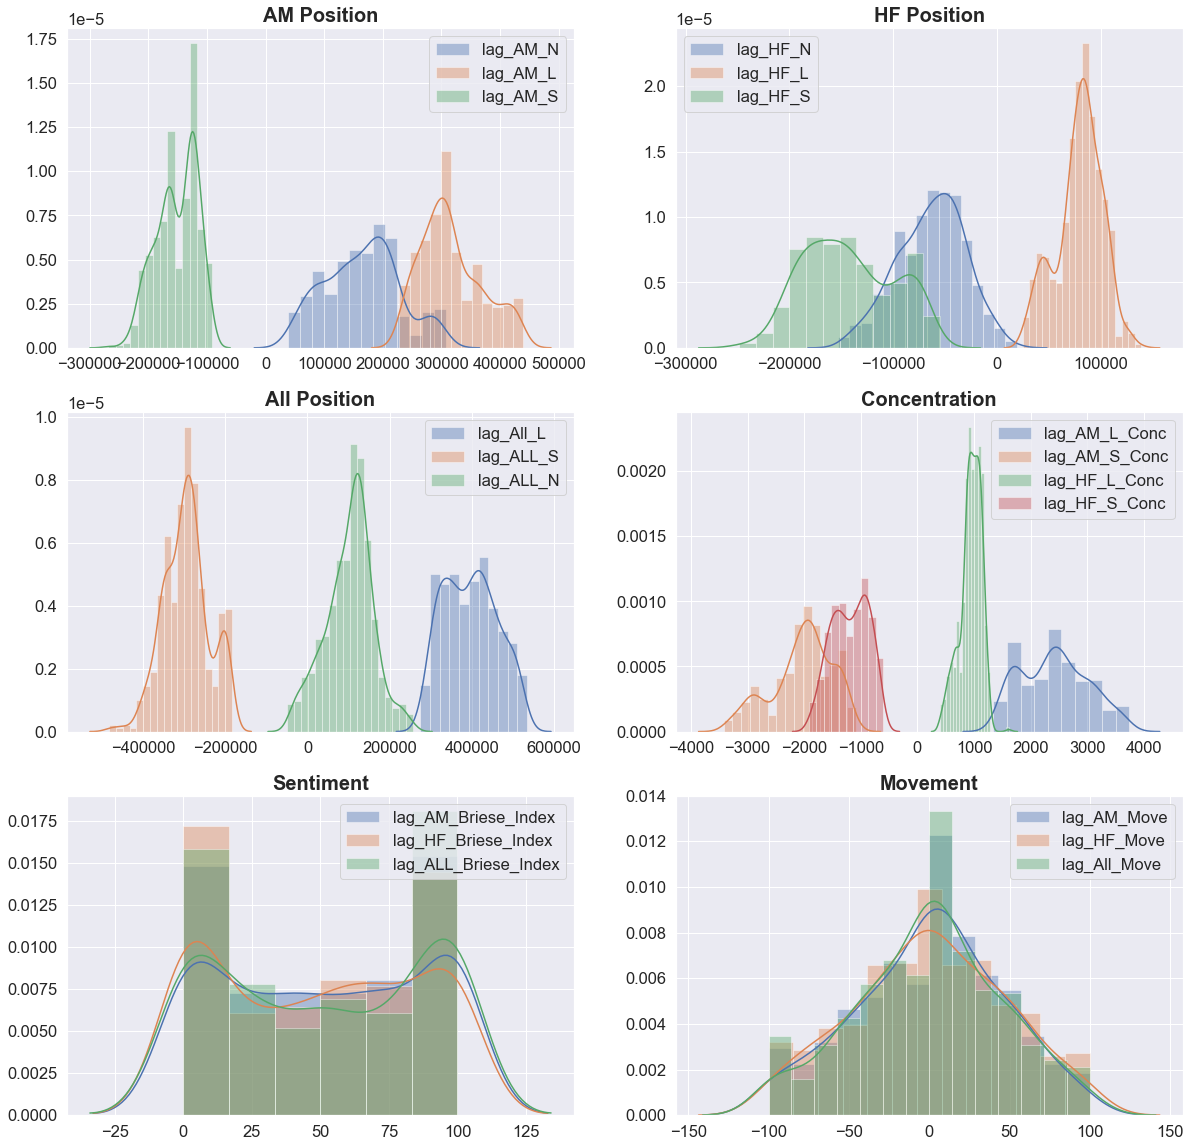

In [12]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[0:6]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        #if(item_names[i][-2:]=="_S"):
        #    x = pd.Series(-df.loc[:,item_names[i]], name = "")
        #else:
        x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

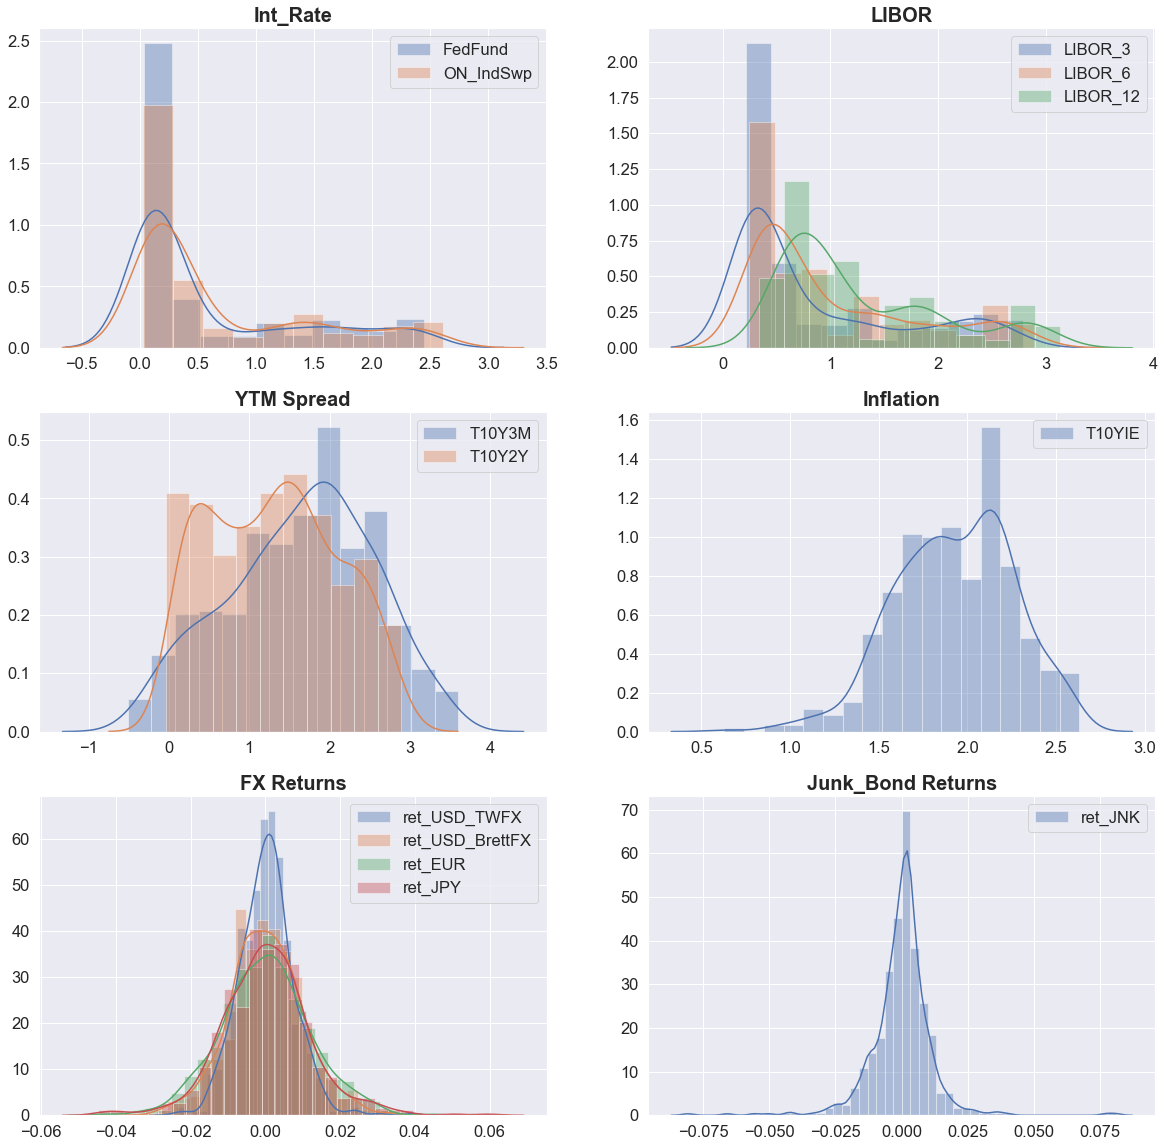

In [13]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[6:12]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            scaler = preprocessing.StandardScaler()
            scaled_sig = scaler.fit_transform(df.loc[:,item_names[i]])
            x = pd.Series(scaled_sig, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [14]:
#standardize client signal
z = df['sum_Client_Signal']
z = z.dropna()
mean = np.mean(z)
std = np.std(z)
z = (z-mean)/std

#look at one of each Asset Type Across Time



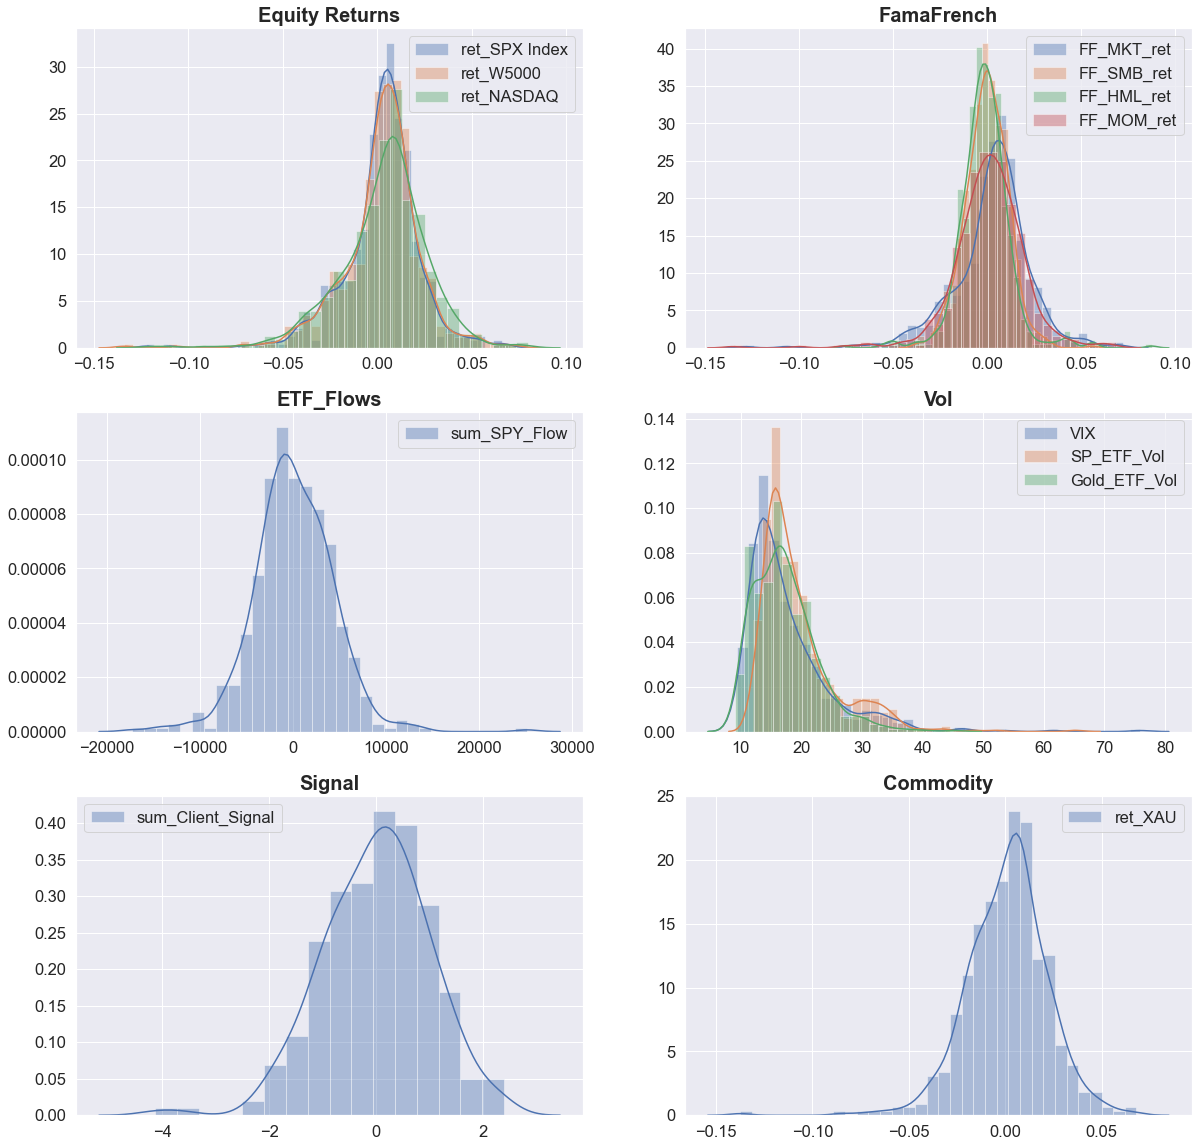

In [15]:
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[12:18]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            x = pd.Series(z, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

#### Predictor / Response Correlations

In [16]:
df['year'] = df.index.year
y_train = df['AM_N']

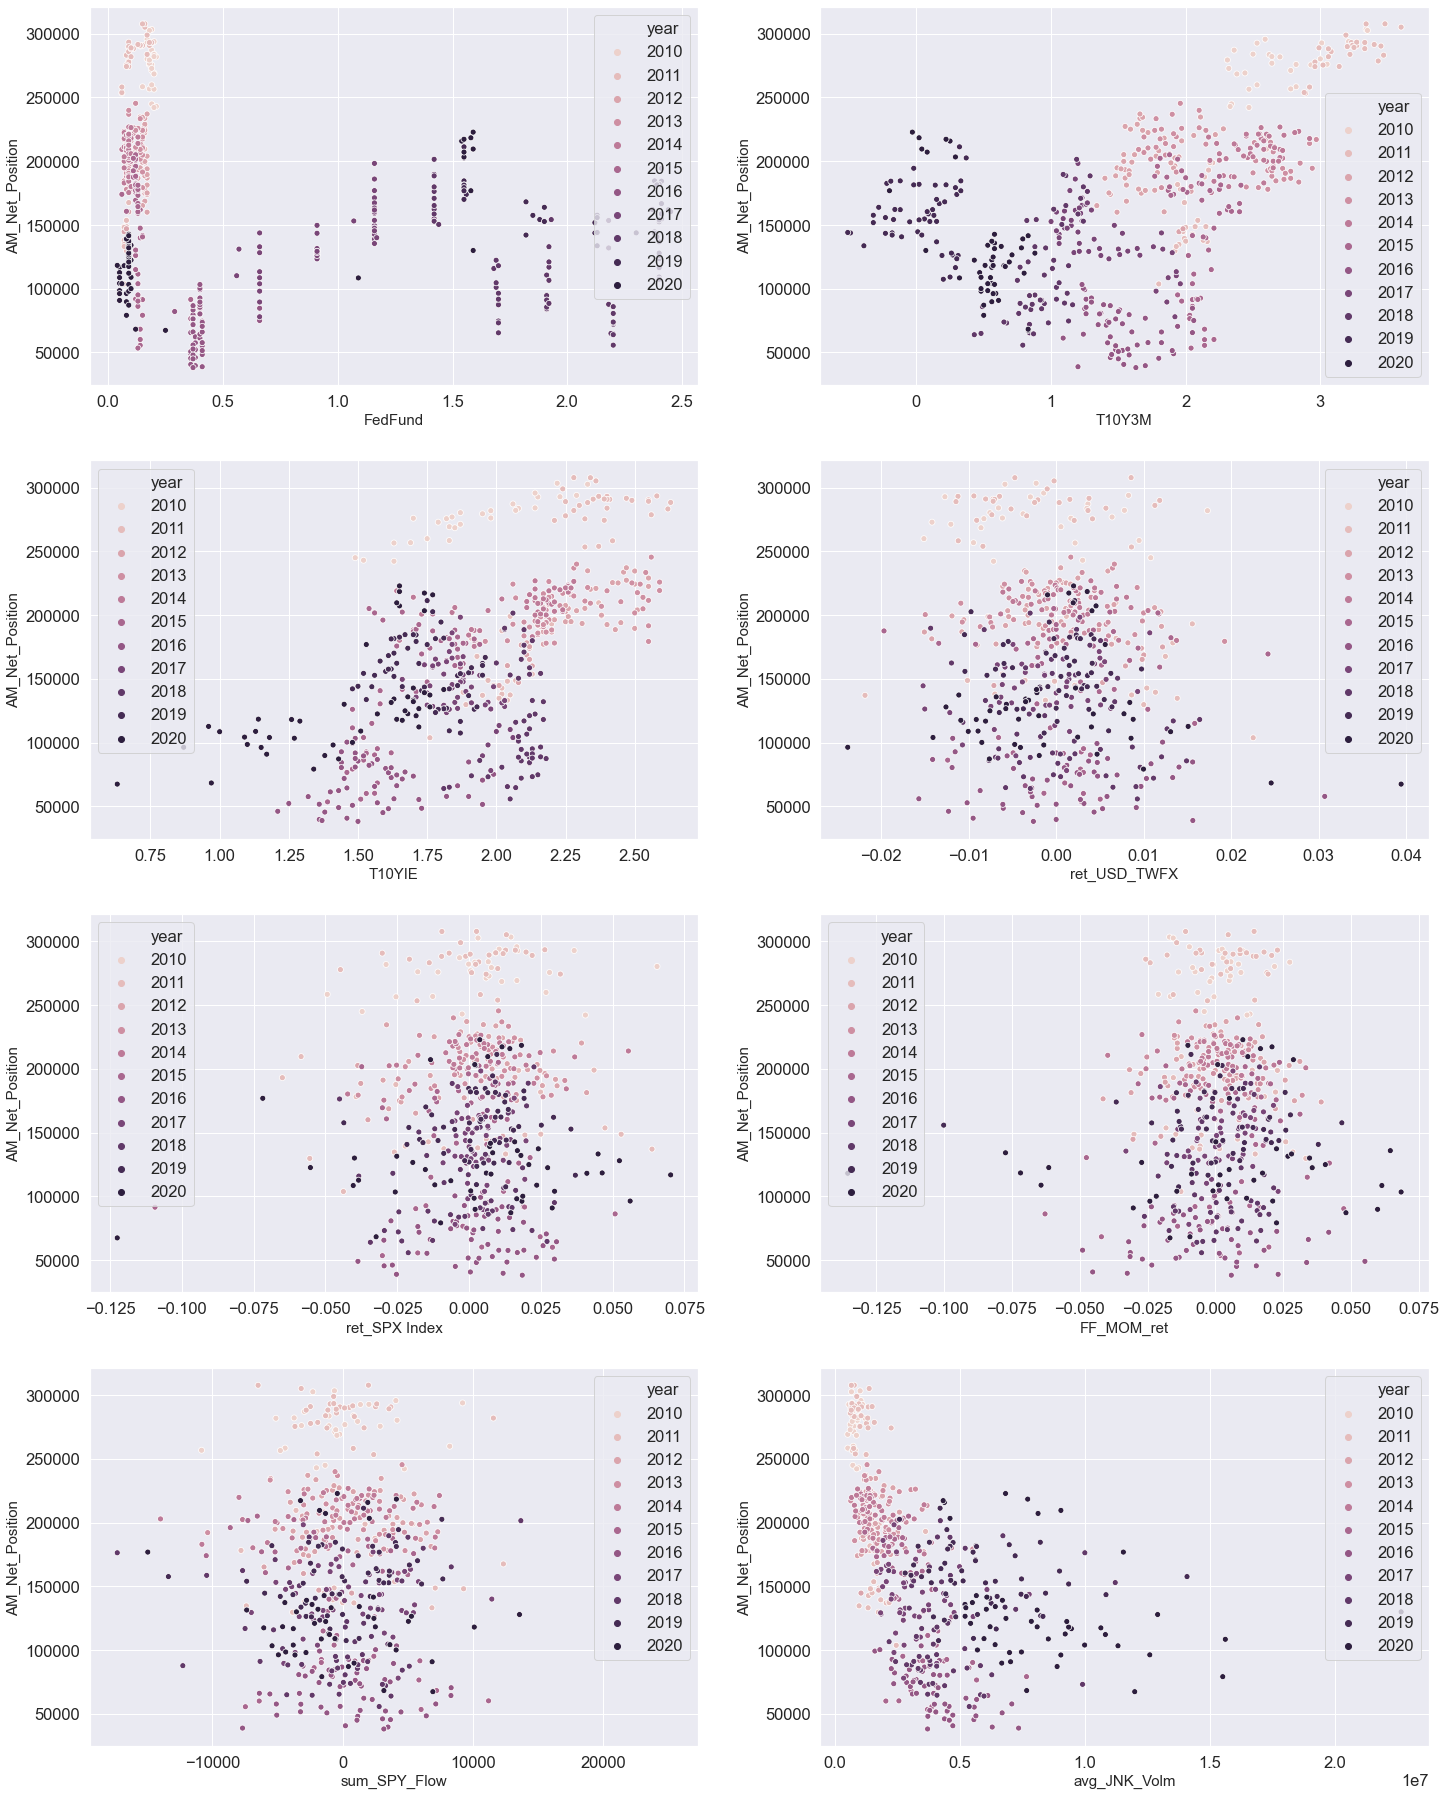

In [17]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

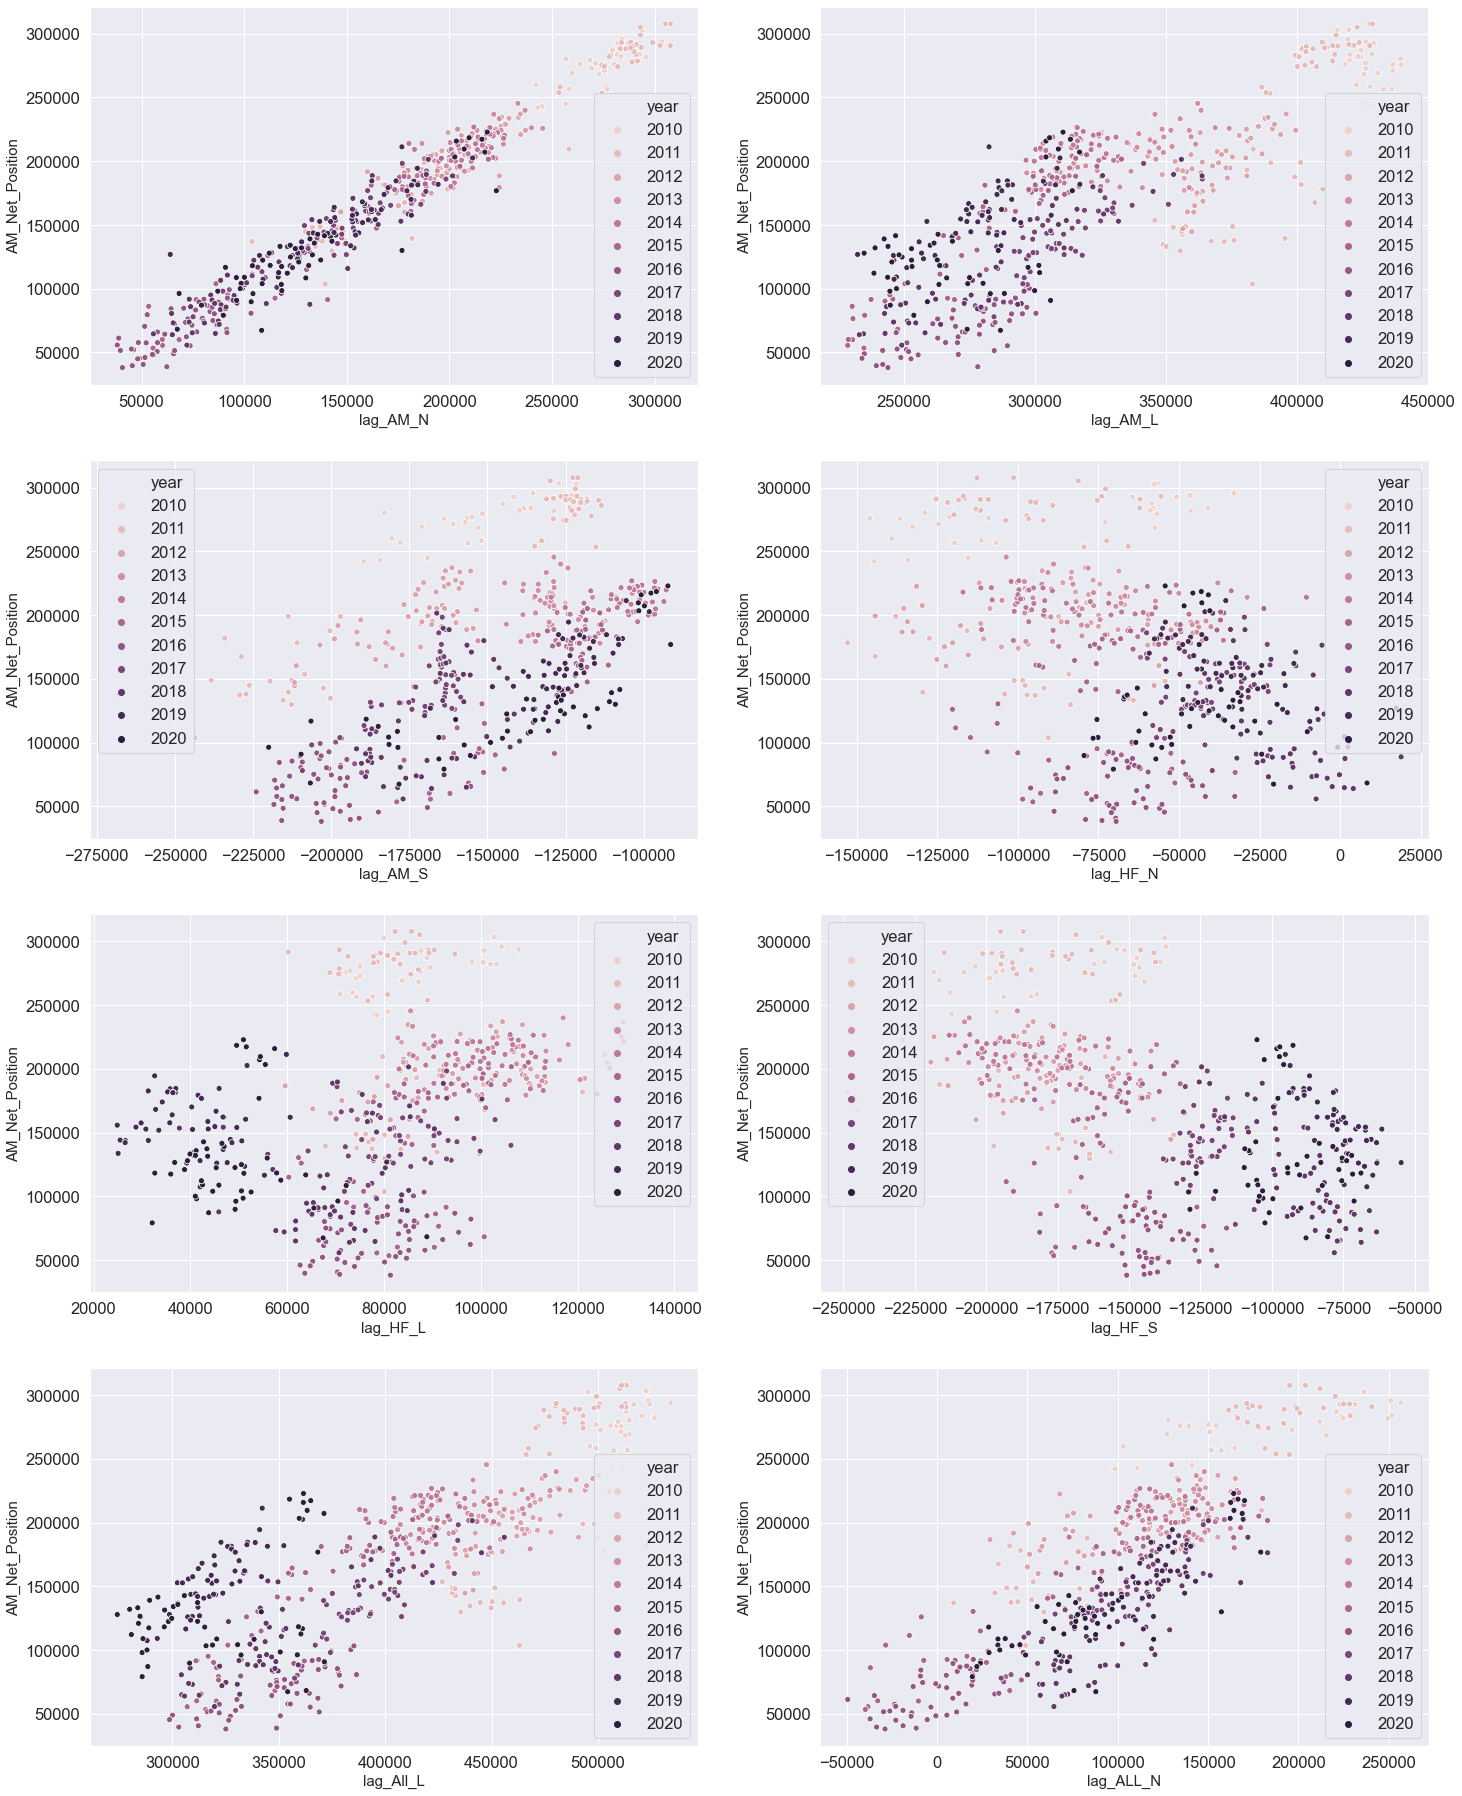

In [18]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


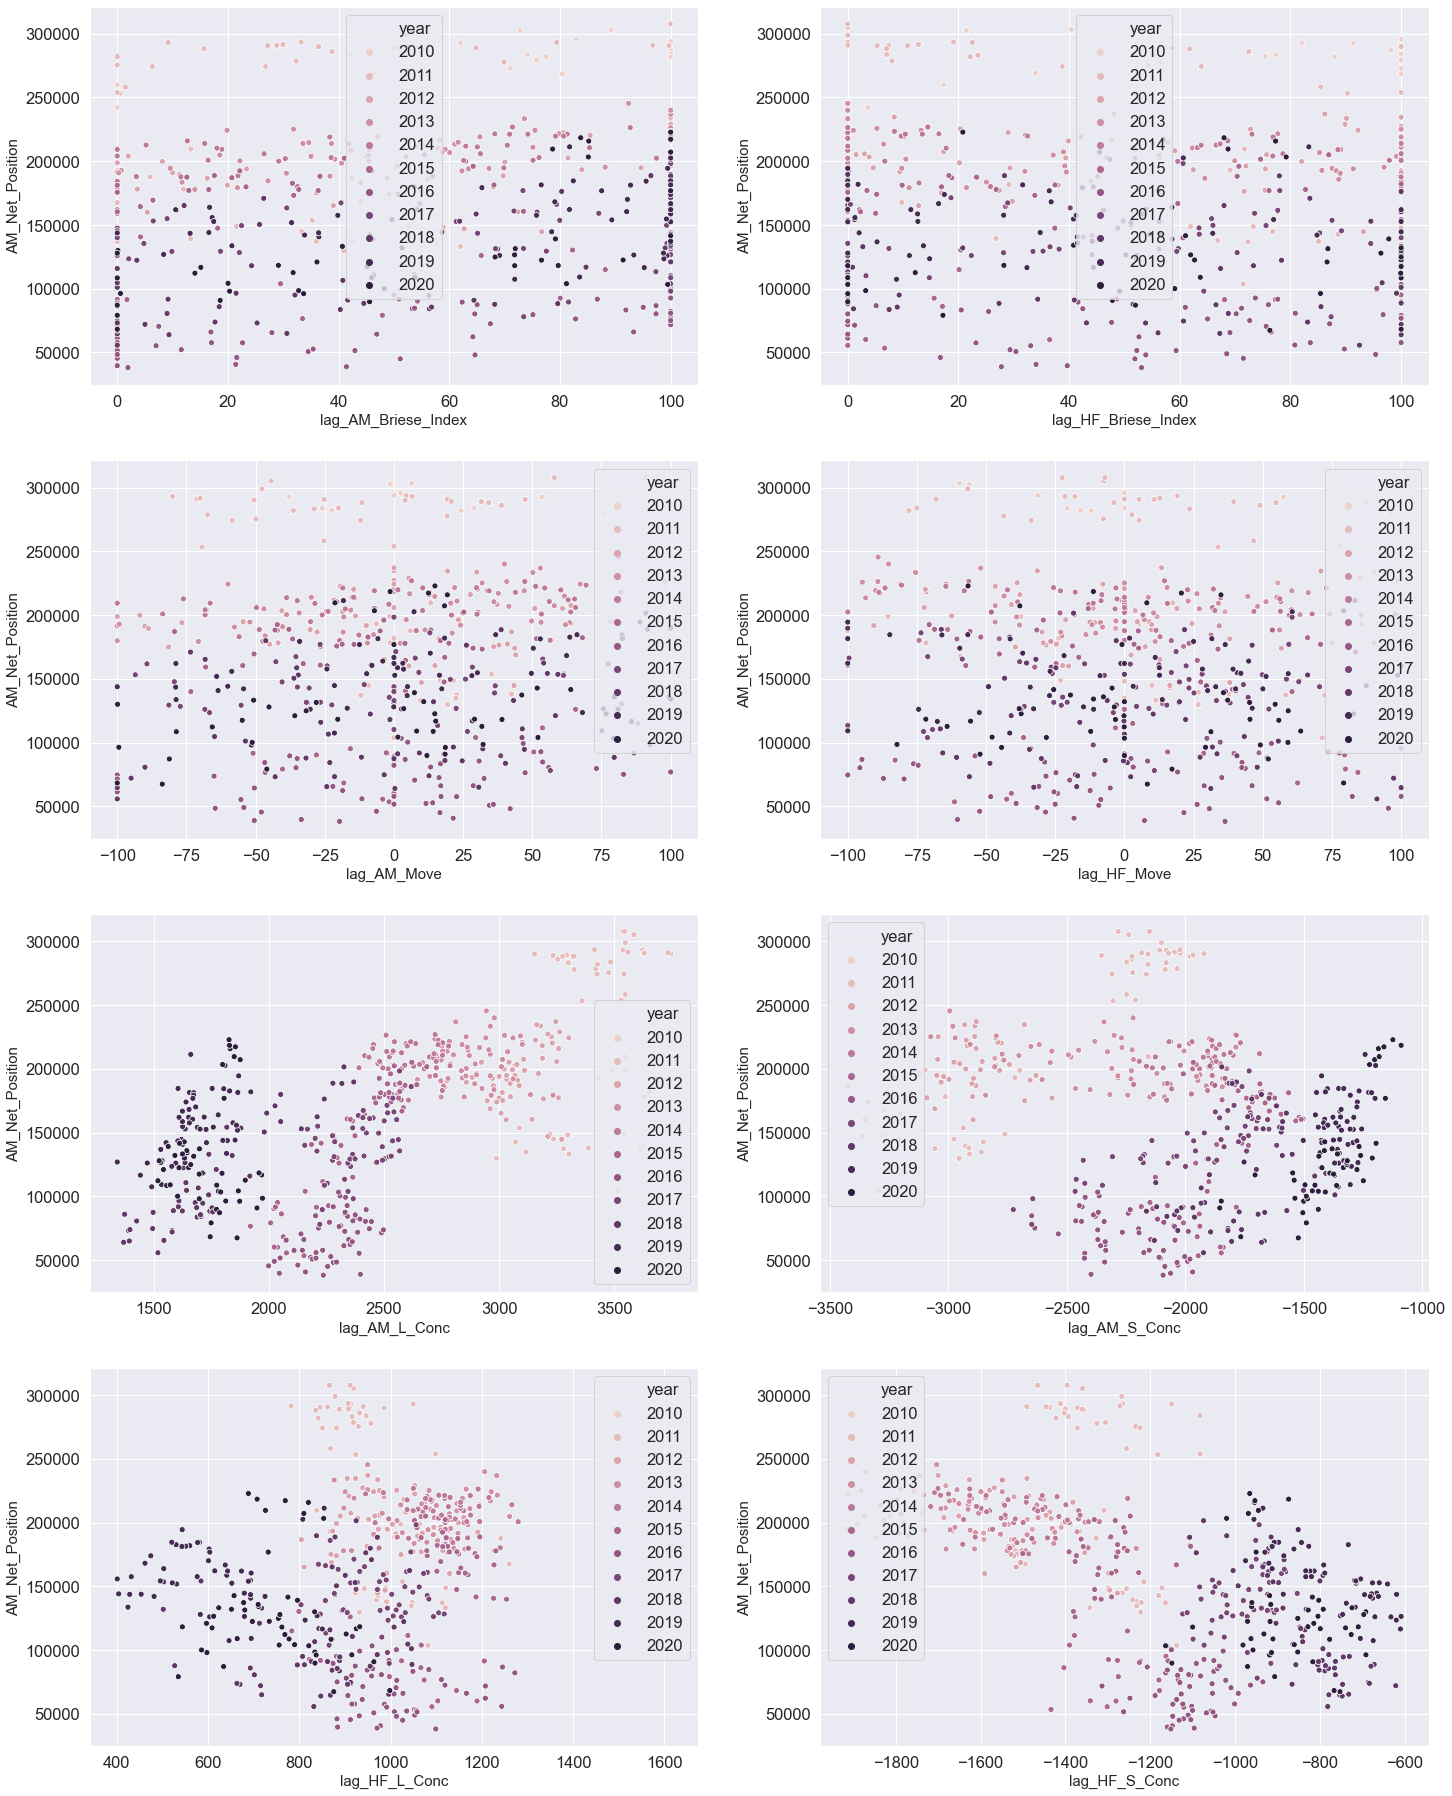

In [19]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_Briese_Index', 'lag_HF_Briese_Index','lag_AM_Move', 'lag_HF_Move', 
       'lag_AM_L_Conc', 'lag_AM_S_Conc', 'lag_HF_L_Conc', 'lag_HF_S_Conc']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]],y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


### Benchmark Model
For the benchmark model, we will attempt to predict the AM_Net_Pos level based on the previous week's value.

In [20]:
df_train.columns

Index(['AM_N', 'FedFund', 'ON_IndSwp', 'LIBOR_3', 'LIBOR_6', 'LIBOR_12',
       'T10Y3M', 'T10Y2Y', 'T10YIE', 'ret_USD_TWFX', 'ret_USD_BrettFX',
       'ret_EUR', 'ret_JPY', 'ret_JNK', 'ret_SPX Index', 'ret_W5000',
       'ret_NASDAQ', 'ret_XAU', 'sum_SPY_Flow', 'avg_JNK_Volm', 'FF_MKT_ret',
       'FF_SMB_ret', 'FF_HML_ret', 'FF_MOM_ret', 'VIX', 'SP_ETF_Vol',
       'Gold_ETF_Vol', 'lag_AM_N', 'lag_AM_L', 'lag_AM_S', 'lag_HF_N',
       'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_S', 'lag_ALL_N'],
      dtype='object')

In [21]:
y_train = df_train['AM_N']
X_train = df_train['lag_AM_N']
X_train = sm.add_constant(X_train)
y_test = df_test['AM_N']
X_test = df_test['lag_AM_N']
X_test = sm.add_constant(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [22]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AM_N   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.22e-292
Time:                        03:23:16   Log-Likelihood:                -4211.5
No. Observations:                 390   AIC:                             8427.
Df Residuals:                     388   BIC:                             8435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2911.0031   1719.576      1.693      0.0

Model: Benchmark
MSE is 210.07
MAE is 10759.58
APE is 0.09


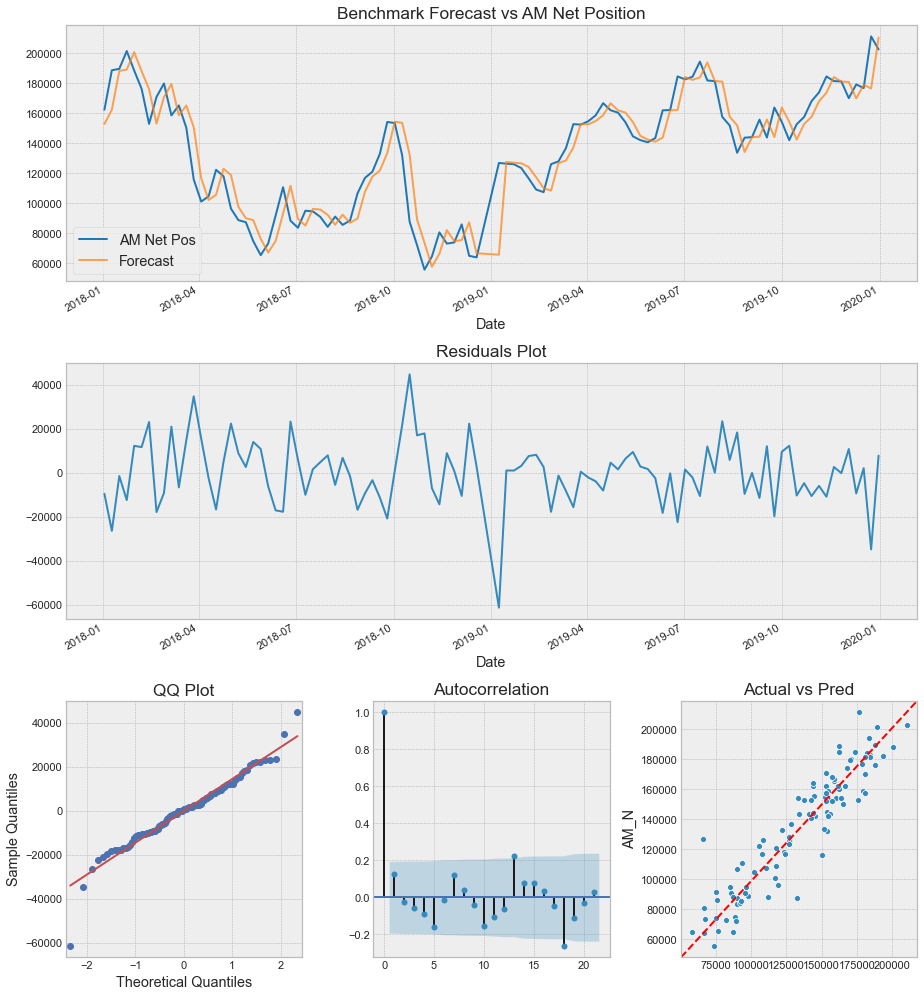

In [23]:
y_pred = results.predict(X_test)
evaluate('Benchmark', y_test, y_pred)

## Position Forecast

#### Lasso
We begin with a rolling estimation window as a way to address local changes in predictor relationships

In [24]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Lasso',123,5)
rebal_dates, rebal_count = Rebal_Dates(df_preCOV, 123, 5)

Model: Lasso
MSE is 122.57
MAE is 8248.25
APE is 0.07


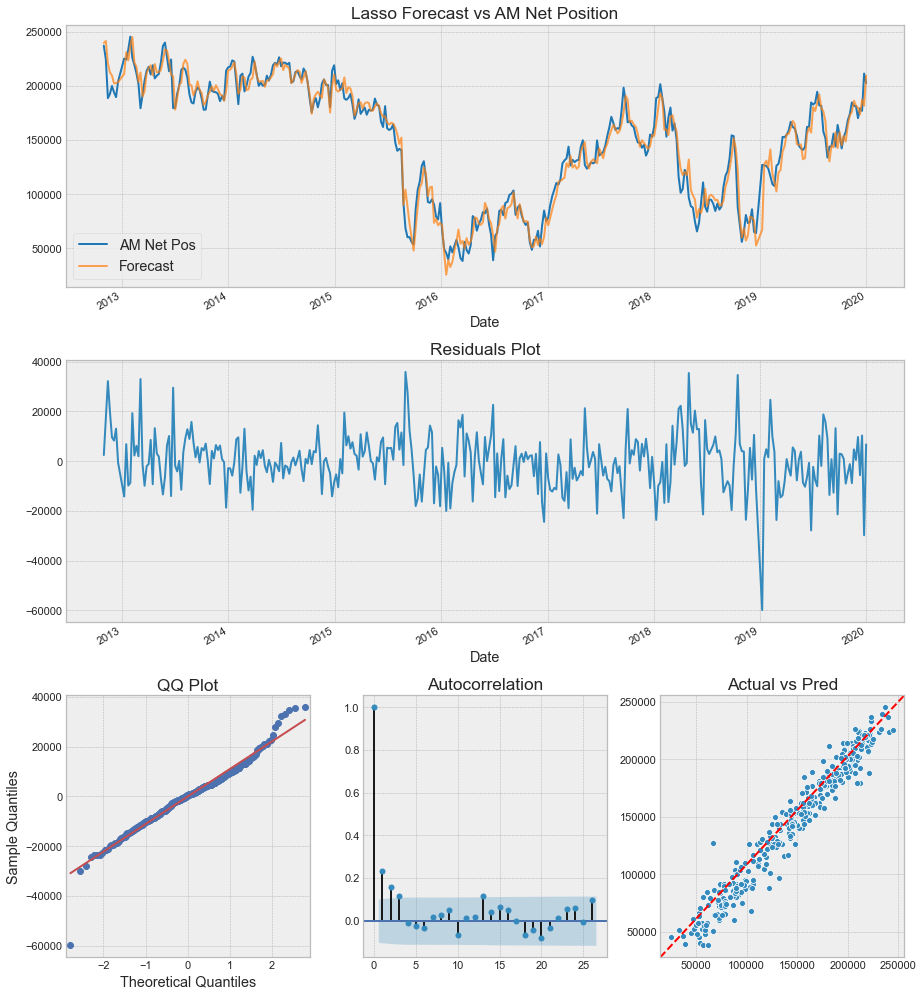

In [25]:
evaluate('Lasso', y_true, pred)

In [26]:
ErrorTest(y_true,pred)

     lb_stat     lb_pvalue
1  20.316071  6.564685e-06
2  29.485300  3.956841e-07
3  34.404735  1.627308e-07 

AIC Order Select: (4, 2)
BIC Order Select: (1, 0)


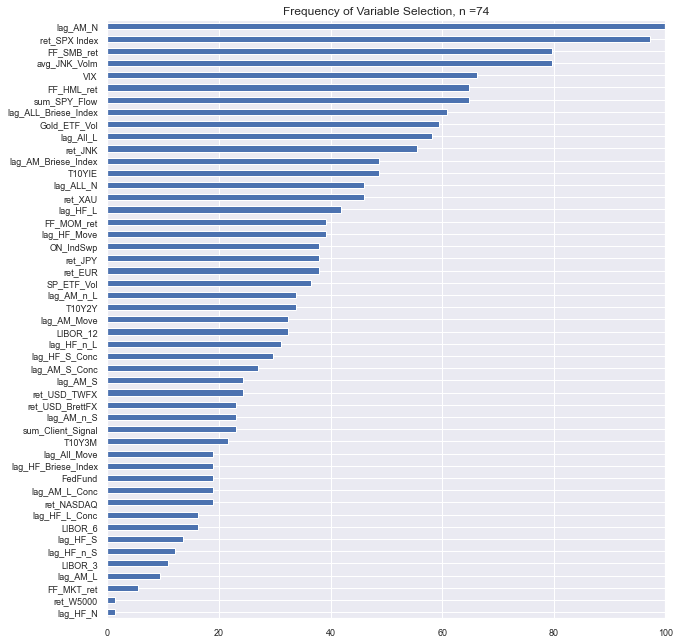

In [27]:
fig = plt.figure(figsize = (10,11))
selected = list(var_sel.values())
flat_sel = [item for sublist in selected for item in sublist]
sel = pd.Series(flat_sel)
pct = sel.value_counts()/rebal_count*100
pct.plot(kind='barh', xlim=(0,100), stacked = True, fontsize = 9)
plt.gca().invert_yaxis()
plt.title("Frequency of Variable Selection, n ="+str(rebal_count))
plt.show()

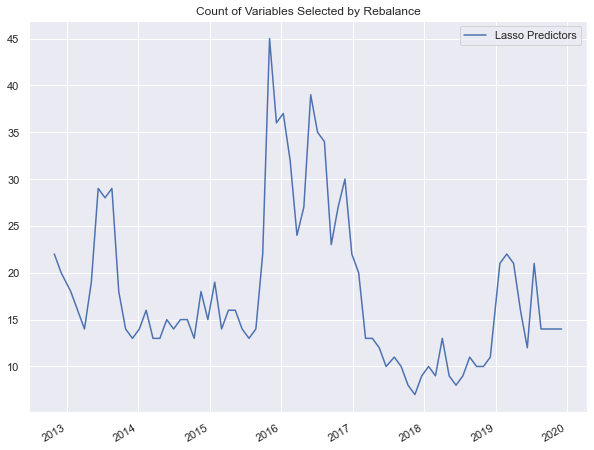

In [28]:
sns.set(font_scale = 1)
length_dict = {key: len(value) for key, value in var_sel.items()}
var_count = list(length_dict.values())
var_count = pd.Series(var_count, index = rebal_dates)
var_count.plot(kind = 'line',title = "Count of Variables Selected by Rebalance", label = "Lasso Predictors", figsize = (10,8))
plt.legend()
plt.show()


#### Ridge

In [29]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Ridge',123,5)


Model: Ridge
MSE is 171.25
MAE is 9769.35
APE is 0.09


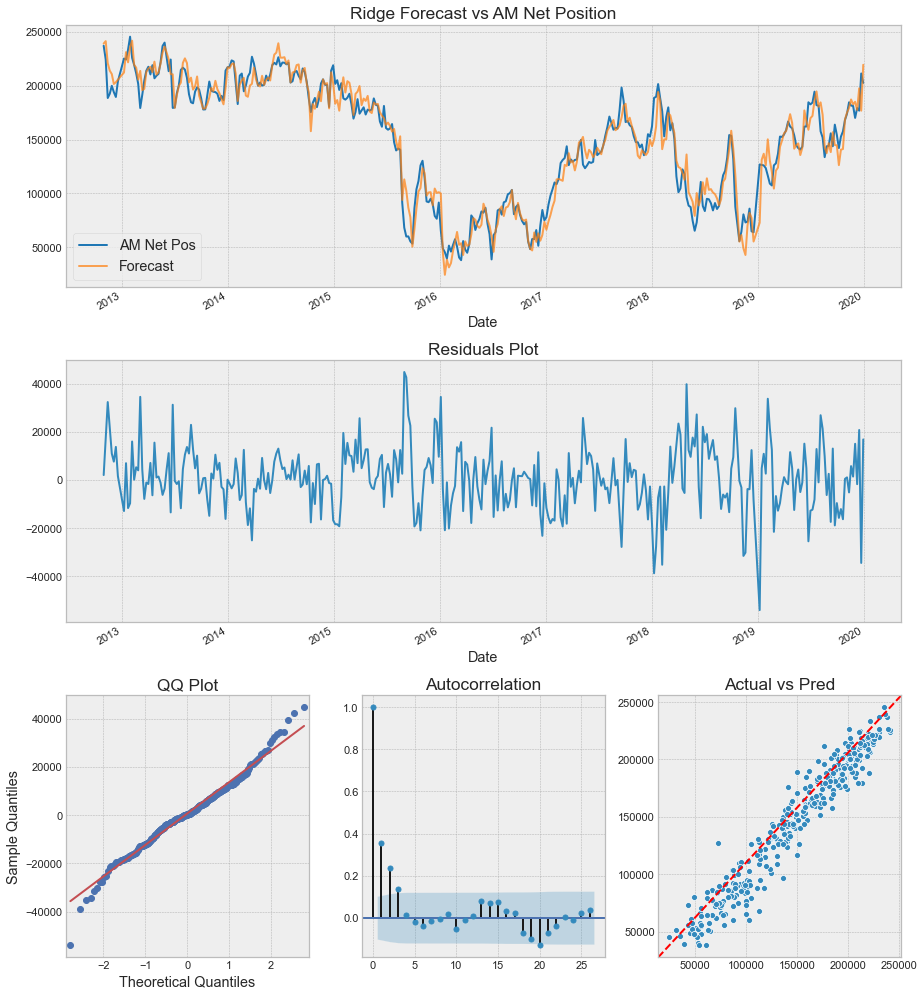

In [30]:
evaluate('Ridge', y_true, pred)

In [31]:
ErrorTest(y_true,pred)

     lb_stat     lb_pvalue
1  46.572463  8.829229e-12
2  67.815003  1.880006e-15
3  74.711478  4.177755e-16 

AIC Order Select: (2, 0)
BIC Order Select: (2, 0)


#### Elastic Net

In [32]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('ElasticNet',123,5)

Model: ElasticNet
MSE is 187.14
MAE is 10247.05
APE is 0.09


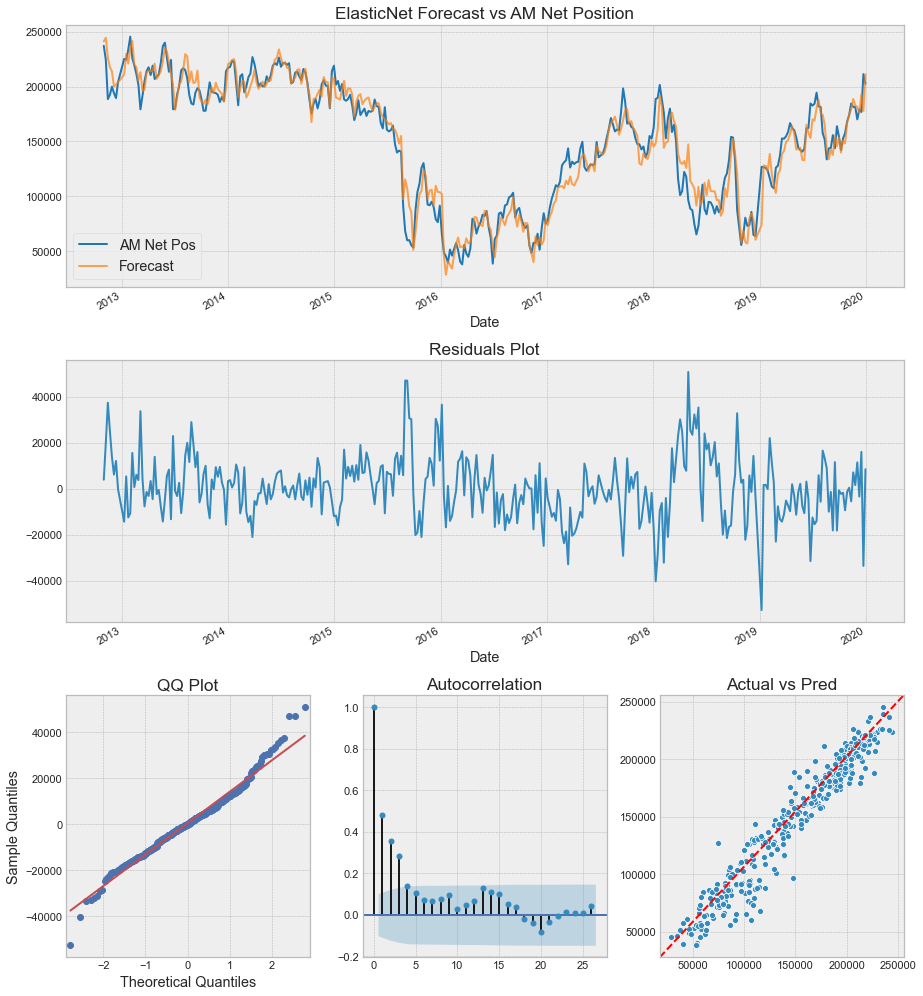

In [33]:
evaluate('ElasticNet', y_true, pred)

In [34]:
ErrorTest(y_true,pred)

      lb_stat     lb_pvalue
1   85.775959  2.015213e-20
2  133.002446  1.314879e-29
3  162.773831  4.618362e-35 

AIC Order Select: (3, 1)
BIC Order Select: (1, 1)


#### SVR

In [41]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('SVReg',223,9)

Model: SVReg
MSE is 3520.93
MAE is 46852.07
APE is 0.58


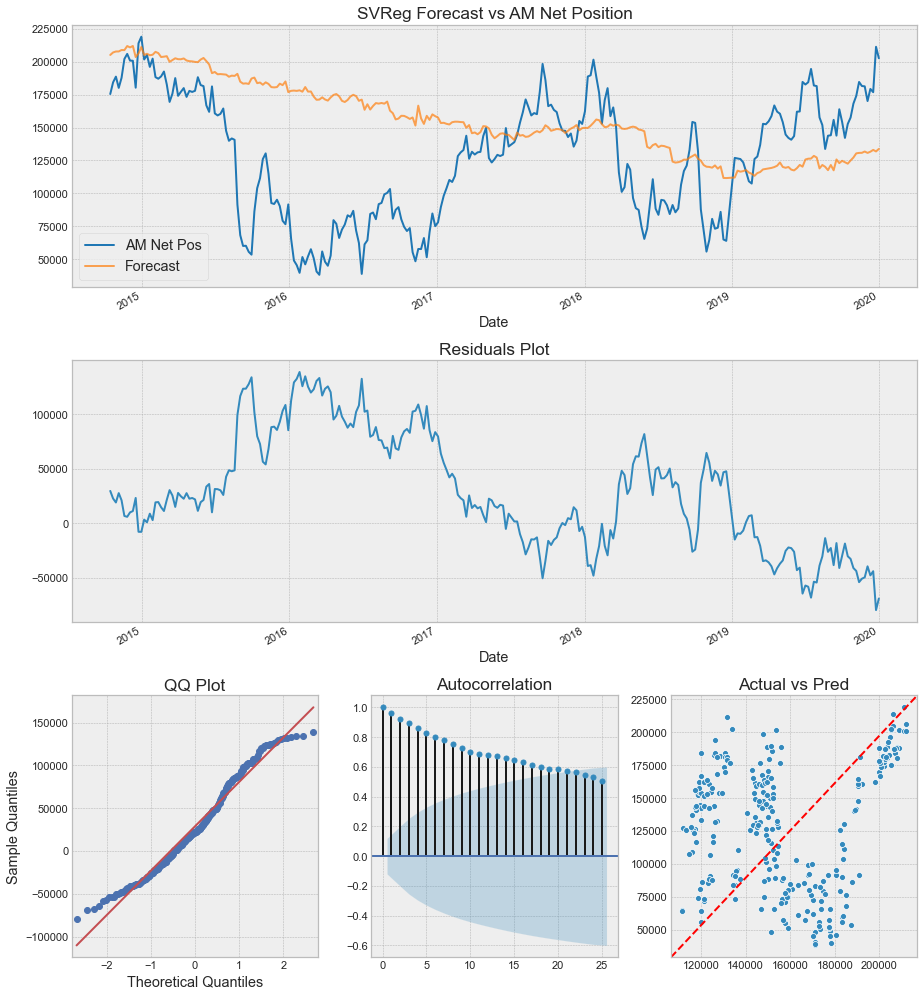

In [42]:
evaluate('SVReg', y_true, pred)

#### GAM

In [37]:
cols = ['AM_N','lag_AM_N','ret_SPX Index','FF_SMB_ret','VIX','sum_SPY_Flow','ret_EUR']
df_train_sel= df_train.reindex(cols,axis="columns")   
df_test_sel=df_test.reindex(cols,axis="columns")   
X_train = df_train_sel.iloc[:,1:]
y_train = df_train_sel.iloc[:,0]
X_test = df_test_sel.iloc[:,1:]
y_test = df_test_sel.iloc[:,0]
r_data_train = pd.concat([X_train, y_train], axis = 1)
r_data_test = pd.concat([X_test, y_test], axis = 1)


#### Random Forest

__Random Forest__

In [38]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Expanding('RF',153,17)

Model: RF
MSE is 590.80
MAE is 18166.17
APE is 0.18


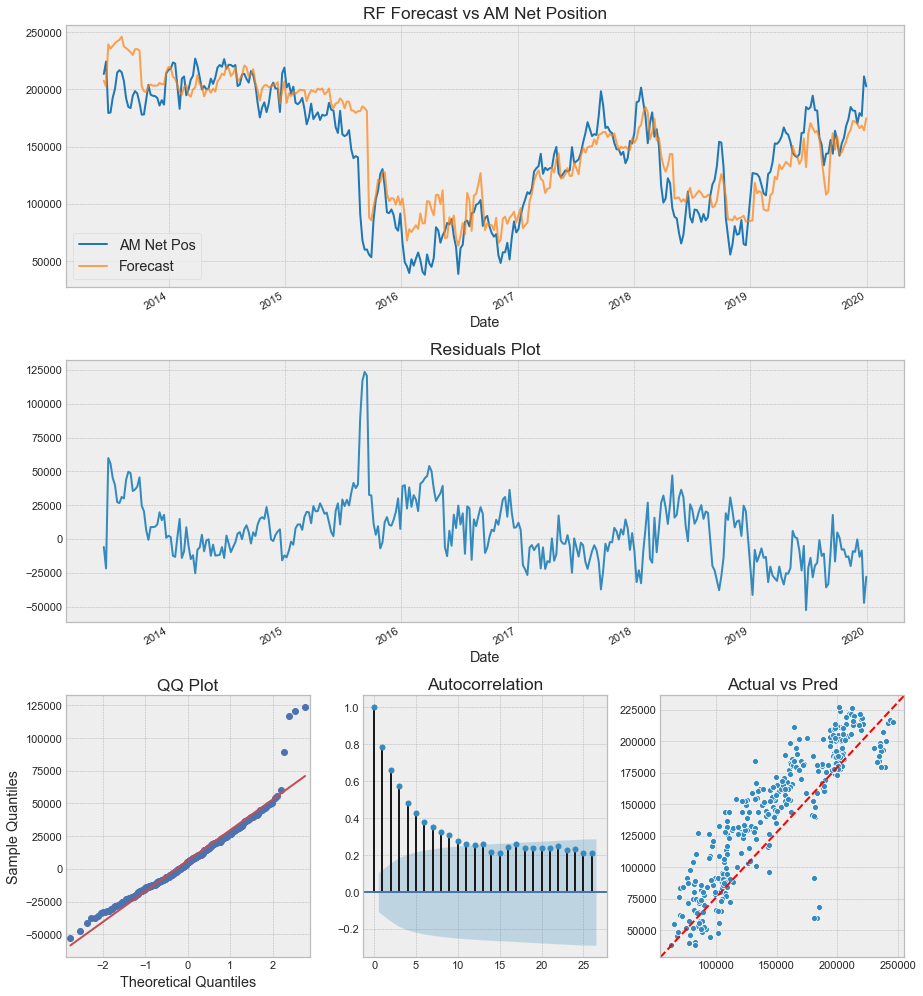

In [39]:
evaluate('RF', y_true, pred)

__Variable Selection__

In [45]:
tscv = TimeSeriesSplit(n_splits = 5)
X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]
X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

#standardize our predictors (std 1, mean 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

feat_importance, forecast = RF(X_train_std, X_test_std, X_train, y_train,tscv)

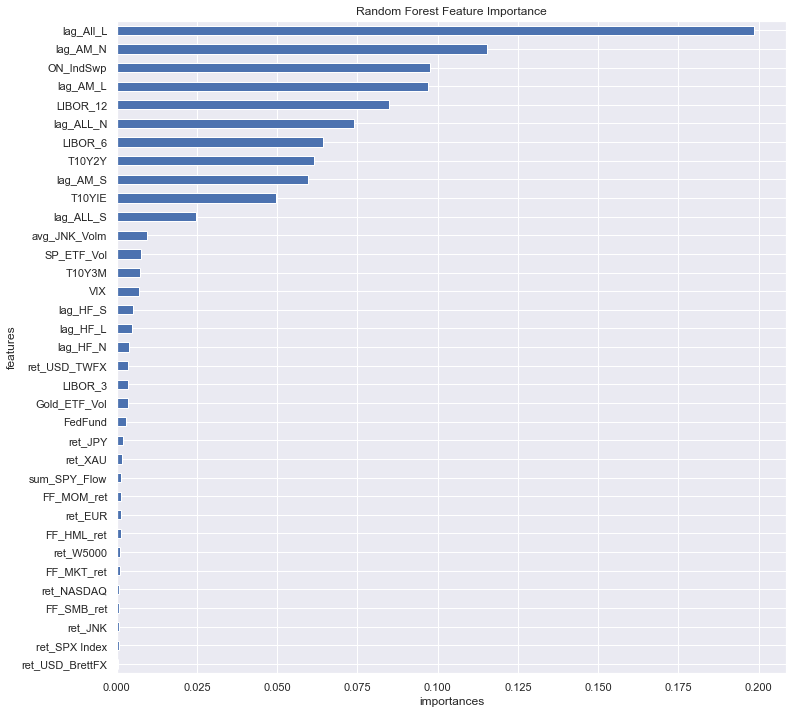

In [46]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

Model: RF_Single
MSE is 830.64
MAE is 24845.43
APE is 0.20


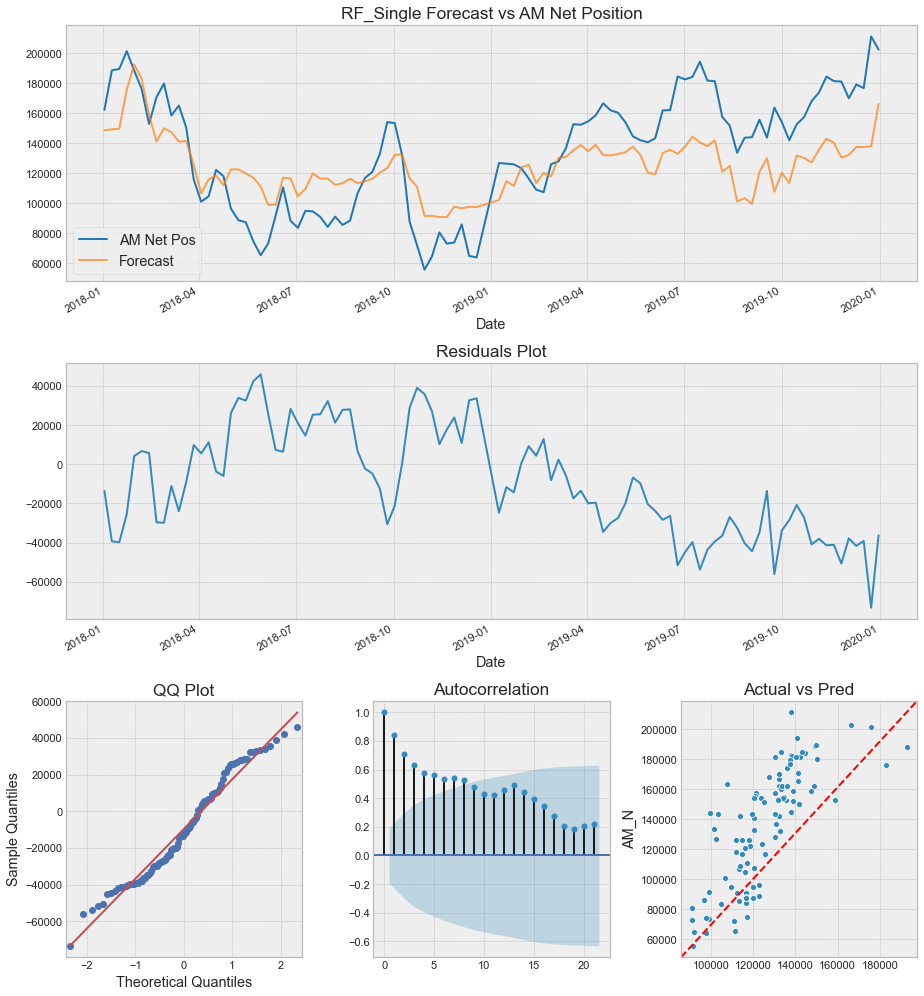

In [47]:
evaluate('RF_Single', y_test, pd.Series(forecast, index = y_test.index))

#### VARMAX

In [ ]:
#pred, MSE, MAE, APE, var_sel, y_true, idx = Expanding('VRMX',350,1)
                

In [ ]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Random Forest Baseline Test")

## Change in AM Position

### Data

In [79]:
df_raw=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date", parse_dates = True)
df_raw['dNetPos'] = df_raw['AM_N'].diff()


In [80]:
df_raw = df_raw.drop(df_raw.index[0])
df_raw = df_raw.drop('AM_N', axis = 1)
col_name='dNetPos'
first_col = df_raw.pop(col_name)
df_raw.insert(0, col_name, first_col)

df_raw.head()

dNetPos  FedFund  ON_IndSwp  LIBOR_3  LIBOR_6  LIBOR_12  T10Y3M  \
Date                                                                          
2010-06-29 -17663.0     0.15     0.2915  0.53300  0.75069   1.17438    2.82   
2010-07-06  -1699.0     0.18     0.2850  0.53113  0.74244   1.16313    2.78   
2010-07-13  23534.0     0.17     0.2760  0.52594  0.73313   1.14500    3.00   
2010-07-20  -4359.0     0.18     0.2490  0.51250  0.71088   1.10188    2.82   
2010-07-27   -346.0     0.19     0.2650  0.48125  0.69431   1.07469    2.93   

            T10Y2Y  T10YIE  ret_USD_TWFX  ...  lag_AM_Briese_Index  \
Date                                      ...                        
2010-06-29    2.36    1.83      0.009476  ...                  NaN   
2010-07-06    2.33    1.69     -0.009447  ...                  NaN   
2010-07-13    2.48    1.87     -0.007572  ...                  NaN   
2010-07-20    2.37    1.70      0.001680  ...                  NaN   
2010-07-27    2.43    1.82     -0.008256  ...                  NaN   

            lag_HF_Briese_Index  lag_ALL_Briese_Index  lag_AM_Move  \
Date                                                                 
2010-06-29                  NaN                   NaN          NaN   
2010-07-06                  NaN                   NaN          NaN   
2010-07-13                  NaN                   NaN          NaN   
2010-07-20                  NaN                   NaN          NaN   
2010-07-27                  NaN                   NaN          NaN   

            lag_HF_Move  lag_All_Move  lag_AM_L_Conc  lag_AM_S_Conc  \
Date                                                                  
2010-06-29          NaN           NaN            NaN            NaN   
2010-07-06          NaN           NaN            NaN            NaN   
2010-07-13          NaN           NaN            NaN            NaN   
2010-07-20          NaN           NaN            NaN            NaN   
2010-07-27          NaN           NaN            NaN            NaN   

            lag_HF_L_Conc  lag_HF_S_Conc  
Date                                      
2010-06-29            NaN            NaN  
2010-07-06            NaN            NaN  
2010-07-13            NaN            NaN  
2010-07-20            NaN            NaN  
2010-07-27            NaN            NaN  

[5 rows x 61 columns]

### EDA: Response

In [81]:
#Drop price columns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df_raw.drop(columns = cols)

#add 2020 to a df
df_insane = df.iloc[-48:,:]

#remove 2020 from the sample, but keep NA vals for now
df_preCOV = df.iloc[:-48,:]

#Now remove NA's before passing to training.  Train and test end up w/ different shapes if you don't drop before this.
df_trimmed = df_preCOV.dropna(axis = 1)

#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
df_train = df_trimmed.iloc[:390,:]
df_test = df_trimmed.iloc[390:,:]


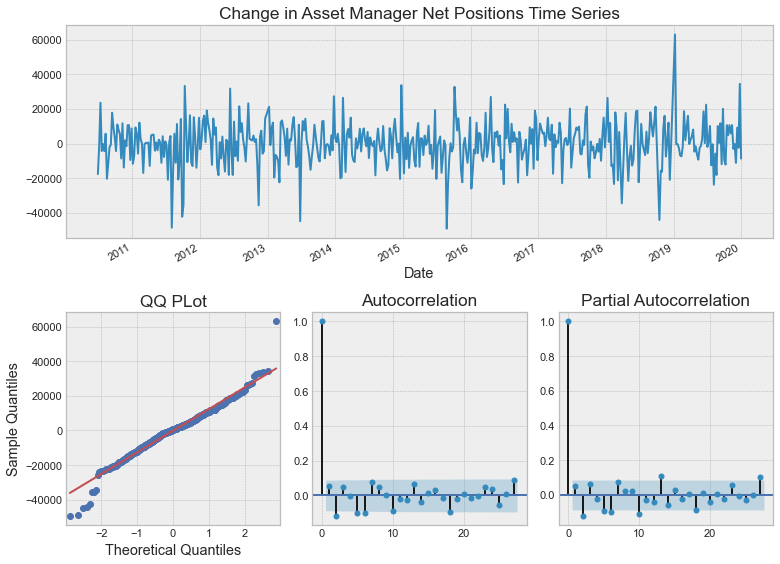

In [83]:
tsplot1(df_preCOV['dNetPos'],title = 'Change in Asset Manager Net Positions Time Series')

In [84]:
res = sm.tsa.arma_order_select_ic(df['dNetPos'], ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (4, 2)
BIC Order Select: (0, 1)


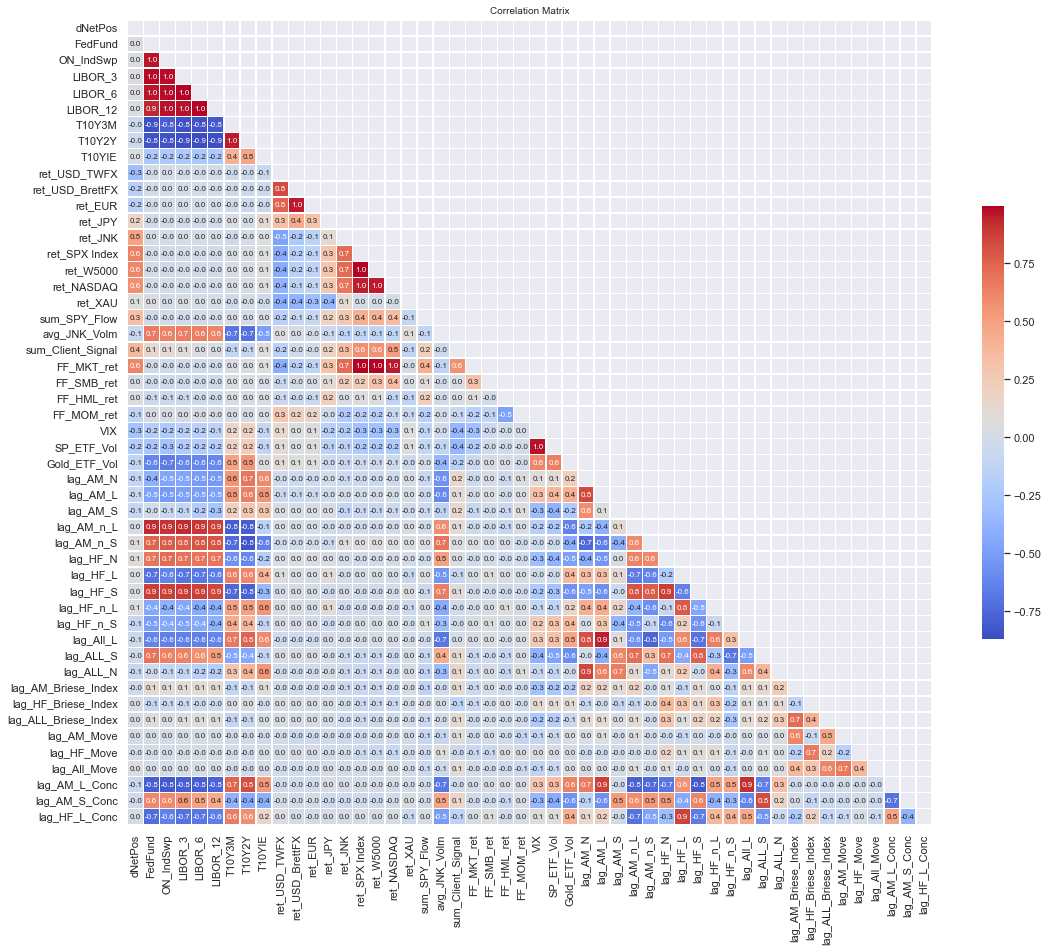

In [87]:
plotCorr(df_preCOV,save=False)

In [88]:
df_preCOV['year'] = df_preCOV.index.year
y_train = df_preCOV['dNetPos']

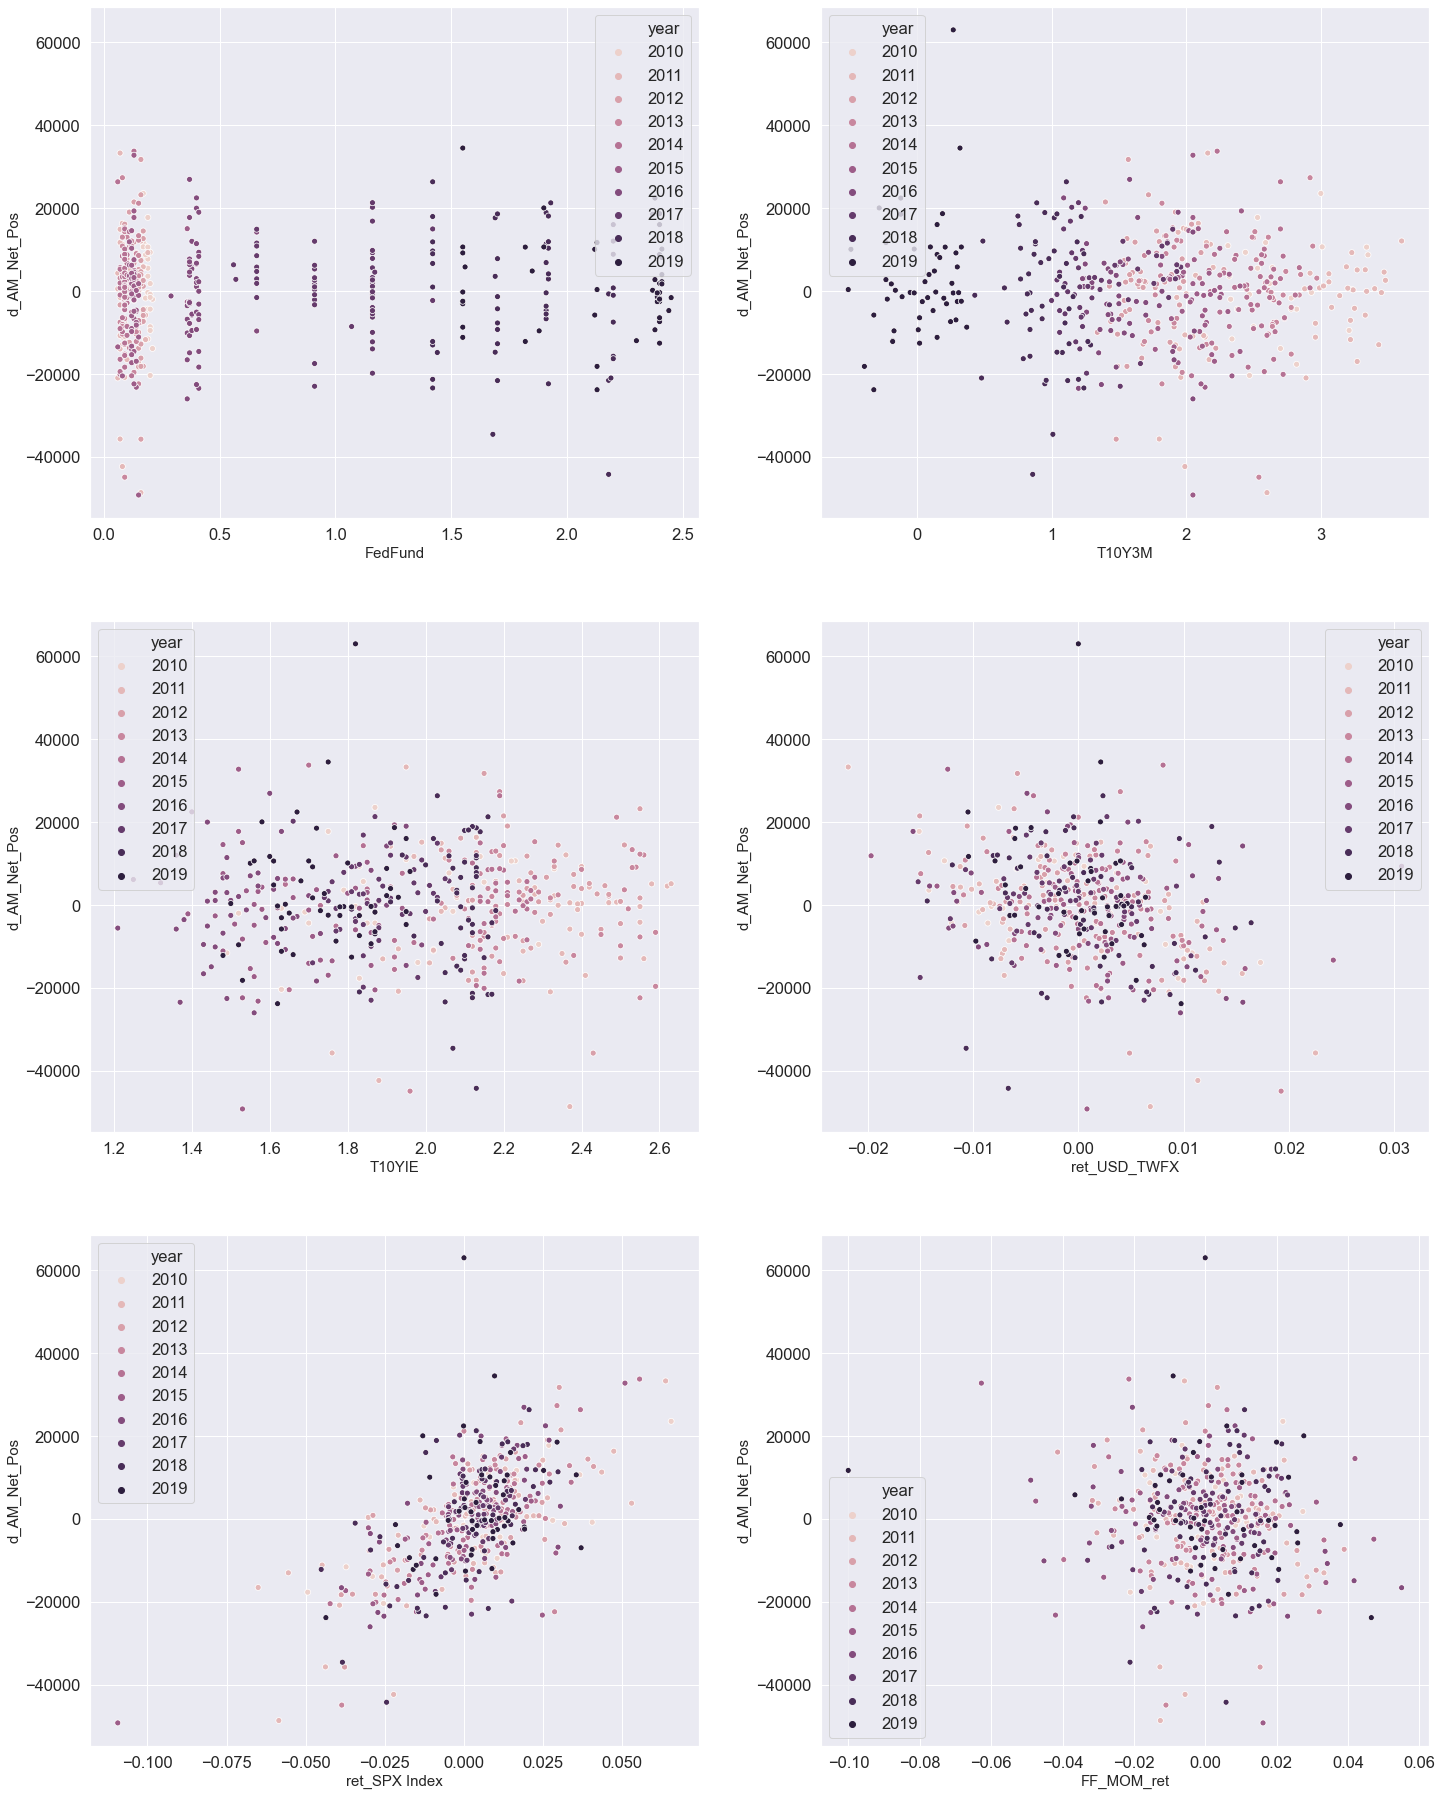

In [91]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(6):
    sns.scatterplot(x=df_preCOV.loc[:,picklst[i]], y=y_train, data=df_preCOV, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Pos", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

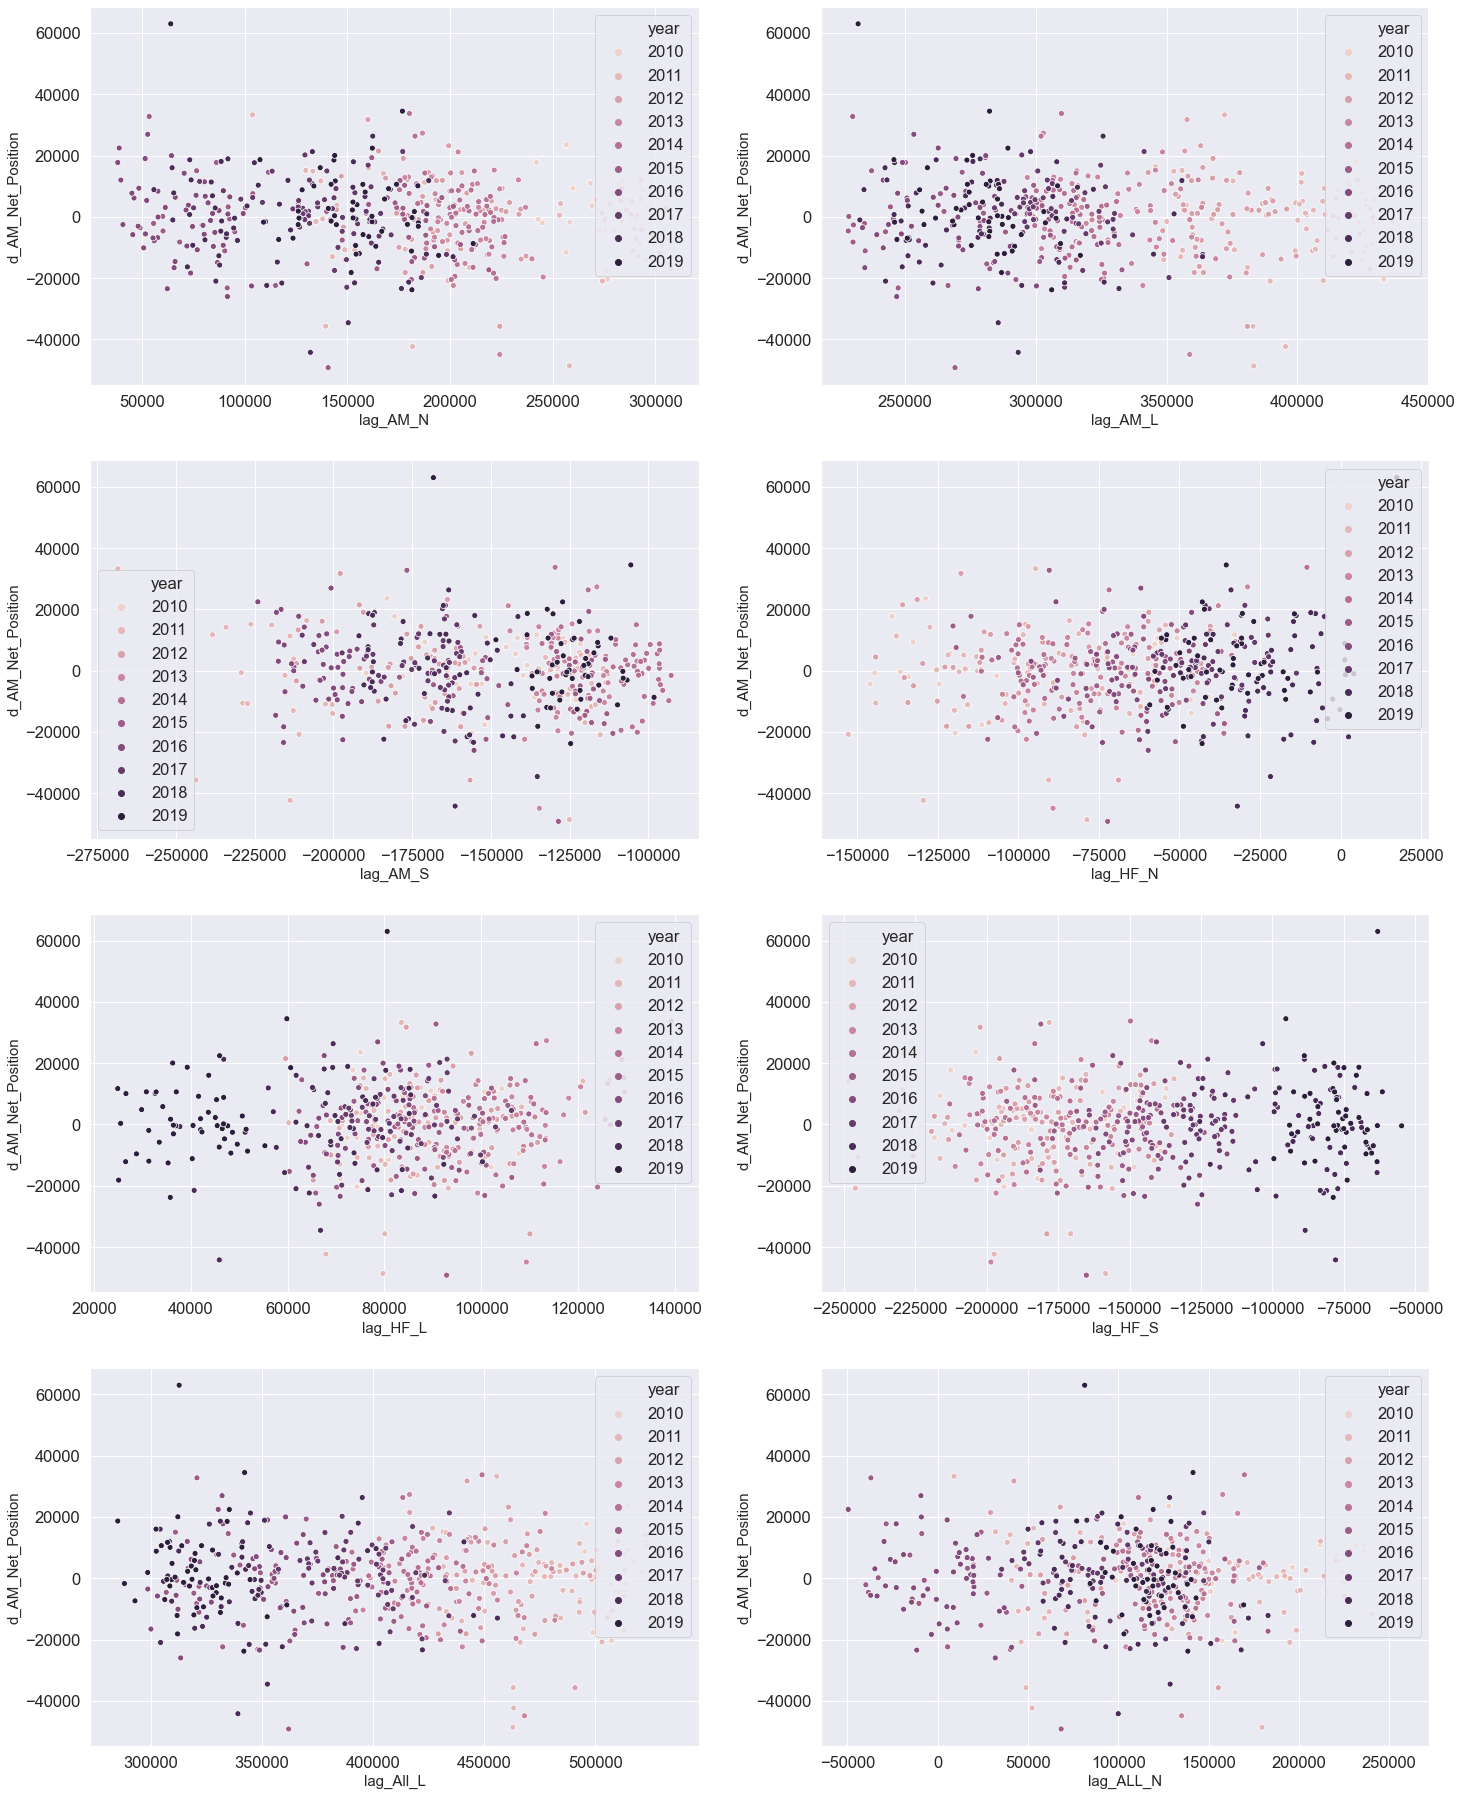

In [95]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df_preCOV.loc[:,picklst[i]], y=y_train, data=df_preCOV, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

In [96]:
df_preCOV = df_preCOV.drop(columns = ['year'])
